### this is my notebook for trying to figure out how to make medical history information into something useful

#### first we import libraries and data

In [1]:
import pandas as pd
import numpy as np

import os
import re
from collections import Counter

import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import sklearn.metrics
import xgboost as xgb

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import random as rn

from IPython.display import clear_output


In [2]:
#use this cell when working online
path = '/floyd/home/ed-triage'
data_path = '/floyd/home/data'

In [3]:
#use this cell when working from home
path = '/Users/jjaskolkambp/Desktop/machine learning/my_projects/ed-triage'
data_path = '/Users/jjaskolkambp/Desktop/machine learning/my_projects/data/ED triage project/combo'

In [4]:
clin = pd.read_csv(data_path + '/complete_clean_combo_data.csv', index_col = 0,low_memory = False)

In [5]:
clin.shape

(165433, 121)

#### then we load up my helper functions

In [6]:

def show_confusion_matrix2(confusion_matrix, labels):
    LABELS = labels

    plt.figure(figsize=(3, 3))
    sns.heatmap(confusion_matrix, cmap = 'Blues', xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 15});
    plt.title("Confusion matrix", fontsize=10)
    plt.ylabel('True label', fontsize=10)
    plt.xlabel('Predicted label', fontsize=10)
    plt.show()
    
def get_metrics(preds , predictions, show_confusion = True, print_output = True, return_values = False):
    
    y_test = targets.numpy()
    
    f1_w = sklearn.metrics.f1_score(y_test, predictions, average='weighted')
    f1 = sklearn.metrics.f1_score(y_test, predictions, average=None)
    acc = sklearn.metrics.accuracy_score(y_test, predictions)
    prec = sklearn.metrics.precision_score(y_test,predictions, average=None) 
    rec = sklearn.metrics.recall_score(y_test,predictions, average=None)
    auroc = sklearn.metrics.roc_auc_score(y_test,preds[:,1], average=None)
    confusion = sklearn.metrics.confusion_matrix(y_test, predictions)
    
    tp, fn, fp, tn = confusion[0,0], confusion[0,1], confusion[1,0], confusion[1,1]
    
    sens = tp/(tp + fn)
    spec = tn/(tn + fp)
    ppv = tp/(tp + fp)
    npv = tn/(tn + fn)
    
    
    if print_output:
        print ('Metrics Report:')
        print ('---------------')
        print ('weighted f1: ', f1_w)
        print ('AUROC:       ',auroc)
        print ('accuracy:    ', acc)
        print ('precision:   ', prec)
        print ('recall:      ', rec)
        print ('sensitivity: ', sens)
        print ('specificity: ', spec)
        print ('PPV:         ', ppv)
        print ('NPV:         ', npv)
        
    if show_confusion:
        show_confusion_matrix2(confusion, labels = data.classes)
     
    if return_values == True:
        return f1_w, auroc, acc, sens, ppv



#### then we clean up the data in the medical history column

In [7]:
history = list(clin['MedicalHistory'].str[16:].astype('str'))

In [8]:
#this is to clean the text in the medical history column (a little bit)
def fixhx(s):
    s =s.replace('<LT><LF>','')
    s = s.replace('<LT>LF>','')
    s =s.replace('Pt.', 'patient')
    s =s.replace('Pt', 'patient')
    s = s.lower()
    s = s.replace('pt.', 'patient')
    s = s.replace('y/o', 'year old')
    s = s.replace('c/o', 'complains of')
    s = s.replace('sob', 'shortness of breath')
    s = s.replace('c/p', 'chest pain')
    s = s.replace('hrs', 'hours')
    s = s.replace('hx', 'history')
    s = s.replace('n/v', 'nausea and/or vomiting')
    s = s.replace('a/e', 'air entry')
    s = s.replace('a/o', 'alert and oriented')
    s = s.replace('a&o', 'alert and oriented')
    s = s.replace('d/c', 'discharge')
    s = s.replace('u/s', 'ultrasound')
    s = s.replace('yrs', 'years')
    s = s.replace('lmp', 'last menstrual period')
    s = s.replace('w/', 'with')
    s = s.replace('@', 'at ')
    s = s.replace('b/c', 'because')
    s = re.sub(r'\bpt.','patient ',s)
    s = re.sub(r'\blt.','left ',s)
    s = re.sub(r'\brt.','right ',s)
    s = re.sub(r'\bmd.','doctor ',s)
    s = re.sub(r'\bra\b','room air ',s)
    s = re.sub(r'\bbp.','blood pressure ',s)
    s = re.sub(r'\bcp.','chest pain ',s)
    s = re.sub(r'\bfd.','family doctor ',s)
    s = s.replace('abx', 'antibiotics')
    s = s.replace(' htn ', ' hypertension ')
    s = re.sub(r'\btyl\b', 'tylenol', s)
    s = re.sub(r'\bprn\b', 'as needed ',s)
    s = re.sub(r'\bvag\b', 'vaginal ',s)
    s = re.sub(r'\bpo\b', 'by mouth ',s)
    s = re.sub(r'\bllq\b', 'left lower quadrant',s)
    s = re.sub(r'\brlq\b', 'right lower quadrant  ',s)
    s = re.sub(r'\bluq\b', 'left upper quadrant',s)
    s = re.sub(r'\bruq\b', 'right upper quadrant  ',s)
    s = re.sub(r'\buti\b', 'urinary tract infection ',s)
    s = re.sub(r'\brd', 'right digit number',s)
    s = re.sub(r'\bld', 'left digit number',s)
    s = re.sub(r'\br\b', 'right ',s)
    s = re.sub(r'\bl\b', 'left ',s)
    s = re.sub(r'\bed\b', 'emergency department ',s)
    s = re.sub(r'\ber\b', 'emergency room ',s)
    s = re.sub(r'\bbm\b', 'bowel movement ',s)
    s = re.sub(r'#\s', 'fracture ', s)
    
    #remove extra white spaces
    s = re.sub(r'\s+', ' ', s)

    #note that what's missing here is removal of punctuation
    return s

In [9]:
replacements = (',','<LT>LF>', '.')
drop_list = ('"', '?')
split_hist = []
for item in history:
    for r in replacements:
        item = item.replace(r, '::')
    
    item = item.split('::')
    
    item = [re.sub(r'\(.*?\)\ *', '', s) for s in item]
    
    item = [fixhx(s) for s in item]
    for d in drop_list:
        item = [x.replace(d,'') for x in item]
    
    item = [x.strip().lower() for x in item if x != 'nan']
    item = [x for x in item if len(x) > 2]
    
    item = list(filter(None, item))
    
    split_hist.append(item)
    

In [10]:
#split hist is a list of lists, where each entry is the list of past medical history conditions for each patient
split_hist[:20]

[['no significant medical history'],
 ['no significant medical history'],
 ['no significant medical history'],
 ['dialysis haemo/pd', 'iddm', 'crf', 'heart problem', 'high cholesterol'],
 ['fibromyalgia'],
 ['enlarged liver'],
 ['anxiety', 'autistic', 'adhd', 'depression', 'asthma', 'celiac'],
 ['no significant medical history'],
 ['hypothyroid'],
 ['anxiety'],
 ['no significant medical history'],
 ['hypertension'],
 ['arthritis', 'copd'],
 ['itp', 'wiscott-aldridge syndrome', 'eczema'],
 ['suicidal attempts', 'depression'],
 ['high cholesterol',
  'hypertension',
  'niddm',
  'cabg',
  'left knee surgery 15 years ago'],
 ['sepsis',
  'urinary tract infection',
  'ca lungs',
  'ca bronchus',
  'hypothyroid',
  'glaucoma cataract/cataract repair',
  'kidney disease',
  'anemia'],
 ['alcoholism'],
 ['gerd', 'high cholesterol'],
 ['hypertension',
  'tia',
  'osteoporosis',
  'diverticulitis',
  'high cholesterol',
  'anxiety',
  'depression',
  'aortic stenosis']]

In [11]:
#creates a list of the number of comborbid conditions of each patient
comorbids = [len(item) if item != ['no significant medical history'] else 0 for item in split_hist]

In [12]:
#rejoining them as a string with diagnoses separated by spaces
join_hist = [' '.join(item) for item in split_hist]

#replacing empty string with NaN
join_hist = [np.nan if item == 'nan' else item for item in join_hist]

len(join_hist)

165433

In [13]:
#join hist converts each patients medical history into a single string with diagnoses separated by commas
join_hist[:20]

['no significant medical history',
 'no significant medical history',
 'no significant medical history',
 'dialysis haemo/pd iddm crf heart problem high cholesterol',
 'fibromyalgia',
 'enlarged liver',
 'anxiety autistic adhd depression asthma celiac',
 'no significant medical history',
 'hypothyroid',
 'anxiety',
 'no significant medical history',
 'hypertension',
 'arthritis copd',
 'itp wiscott-aldridge syndrome eczema',
 'suicidal attempts depression',
 'high cholesterol hypertension niddm cabg left knee surgery 15 years ago',
 'sepsis urinary tract infection ca lungs ca bronchus hypothyroid glaucoma cataract/cataract repair kidney disease anemia',
 'alcoholism',
 'gerd high cholesterol',
 'hypertension tia osteoporosis diverticulitis high cholesterol anxiety depression aortic stenosis']

### exploring different diagnoses

In [14]:
diagnoses = Counter()
for hx in split_hist:
    for item in hx:
        diagnoses[item] += 1

In [15]:
#there are 23721 different medical histories used in the dataset!!!
len(diagnoses)

23721

In [16]:
#sorted diagnoses
diagnoses.most_common(40)

[('no significant medical history', 73713),
 ('hypertension', 21703),
 ('high cholesterol', 19767),
 ('niddm', 12394),
 ('htn', 7693),
 ('asthma', 6974),
 ('high bp', 6399),
 ('depression', 6375),
 ('thyroid', 4936),
 ('anxiety', 4855),
 ('hypothyroid', 3981),
 ('iddm', 3800),
 ('gerd', 3409),
 ('diabetes', 3257),
 ('acid reflux', 2420),
 ('arthritis', 2220),
 ('anemia', 1706),
 ('copd', 1511),
 ('high chol', 1283),
 ('chf', 1172),
 ('schizophrenia', 1154),
 ('gout', 1120),
 ('seizure', 1057),
 ('kidney stones', 1021),
 ('enlarged prostate', 1016),
 ('cva', 1011),
 ('atrial fibrillation', 952),
 ('dementia', 924),
 ('cholesterol', 893),
 ('migraines', 874),
 ('adhd', 794),
 ('osteoporosis', 784),
 ('bipolar', 723),
 ('chronic back pain', 717),
 ('afib', 716),
 ('immunizations up to date', 688),
 ('smoker', 675),
 ('cad', 624),
 ('fibromyalgia', 601),
 ('substance misuse', 597)]

In [17]:
diagnoses.most_common()[-40:]

[('tear in aorta', 1),
 ('vertebra fracture', 1),
 ('ulcers both feet', 1),
 ('wallerian degenration', 1),
 ('hemiplegia at birth', 1),
 ('ventricular enlargement', 1),
 ('myocaridial infarction five years ago', 1),
 ('stroke fifteen years ago', 1),
 ('bilateral lung transplant', 1),
 ('copa syndrome', 1),
 ('cellulitis developed from c-section', 1),
 ('low hg-blood transfusion 3months ago', 1),
 ('back injury -high chol', 1),
 ('hashimotos-auto immune ds', 1),
 ('prolactin level high-', 1),
 ('stent-heart blockage', 1),
 ('torn ligament of left leg', 1),
 ('bilateral lower leg amputations', 1),
 ('currently being assessed for delirium', 1),
 ('stent 9 months ago', 1),
 ('legs paralyed', 1),
 ('5 tetnts 2018', 1),
 ('carotid sx', 1),
 ('demyleanating neuropathy', 1),
 ('paresthesia', 1),
 ('type ii diabetes', 1),
 ('unspecified heart disease', 1),
 ('list', 1),
 ('c6 stenosis', 1),
 ('left femur fracture three years ago', 1),
 ('abaltion st', 1),
 ('mikes on march 26', 1),
 ('select fr

In [18]:
#this turns the num_diagnoses of classes into a dict where each class has a number
#this assumes the counter has already been made
#this also assumes the medical history has already been split into a list of diagnoses

def multihot_encode(counter, split_hist, num_diagnoses):
    class_dict = {finding[0]:i for i,finding in enumerate(counter.most_common(num_diagnoses))}

    #this creates a large array containing a 1 in each column where there is a diagnosis
    complete_findings = np.empty((len(split_hist), len(class_dict)+1))
    for idx,findings in enumerate(split_hist):
        findings_array = np.zeros(len(class_dict)+1)
        for finding in findings:
            try:
                findings_array[class_dict[finding]] = 1
            except:
                findings_array[len(class_dict)] = 1
        complete_findings[idx,:]= findings_array

    complete_findings.shape

    #this turns the above array into a dataframe
    findings_df = pd.DataFrame(complete_findings.astype(int), columns = list(class_dict.keys()) + ['other'])
    print (f'There are {num_diagnoses} diagnoses, {findings_df.shape[1] - num_diagnoses} unknowns and {len(findings_df)} patients in the encoded dataframe')
    return findings_df, complete_findings

In [159]:
small_findings, _ = multihot_encode(diagnoses, split_hist, 1000)

There are 1000 diagnoses, 1 unknowns and 165433 patients in the encoded dataframe


In [120]:
#small_findings.to_csv(data_path + '/top_1000_pmhx.csv', index = False)

### now to try using these features to train a tabular fast.ai model

In [221]:
from fastai import *
from fastai.tabular import *

import random

from sklearn.metrics import confusion_matrix
import sklearn.metrics
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

#### 1000 patients, 1000 diagnoses

In [222]:
small_findings, _ = multihot_encode(diagnoses, split_hist, 1000)

small_findings['discharge'] = clin['discharge']

There are 1000 diagnoses, 1 unknowns and 165433 patients in the encoded dataframe


In [223]:
test_df = small_findings.sample(1000)

test_df.shape

(1000, 1002)

In [224]:
cat_names = list(test_df.columns)[:-1]
dep_var = 'discharge'  

procs = [FillMissing, Categorify, Normalize]
test = TabularList.from_df(test_df.copy(), cat_names=cat_names)

data = (TabularList.from_df(test_df, path=path, cat_names=cat_names, procs=procs)
                           .split_by_rand_pct()
                           .label_from_df(cols=dep_var)
                           .add_test(test)
                           .databunch())


In [225]:
layers = [100,50]
epochs = 10
lr = 5e-2 

In [226]:
print ('1000 patients, 1000 diagnoses')
learn = tabular_learner(data, layers, metrics=[accuracy])
learn.fit_one_cycle(epochs, lr)


1000 patients, 1000 diagnoses


epoch,train_loss,valid_loss,accuracy,time
0,0.686499,0.496069,0.940000,00:05
1,0.547316,0.499063,0.940000,00:05
2,0.463969,9.111872,0.940000,00:05
3,0.400833,7.391672,0.940000,00:04
4,0.349066,8.863023,0.940000,00:04
5,0.316807,0.904135,0.940000,00:05
6,0.293682,10.918314,0.060000,00:04
7,0.271891,0.444110,0.900000,00:04
8,0.256904,0.253522,0.940000,00:04
9,0.246857,0.246701,0.940000,00:05


#### 10000 patients, 1000 diagnoses

In [227]:
test_df = small_findings.sample(10000)
cat_names = list(test_df.columns)[:-1]
dep_var = 'discharge'  

#procs = [FillMissing, Categorify, Normalize]
test = TabularList.from_df(test_df.copy(), cat_names=cat_names)

data = (TabularList.from_df(test_df, path=path, cat_names=cat_names, procs=procs)
                           .split_by_rand_pct()
                           .label_from_df(cols=dep_var)
                           .add_test(test)
                           .databunch())

In [228]:
print ('10000 patients, 1000 diagnoses')
learn = tabular_learner(data, layers, metrics=[accuracy])
learn.fit_one_cycle(epochs, lr)

10000 patients, 1000 diagnoses


epoch,train_loss,valid_loss,accuracy,time
0,0.351754,2.216266,0.911000,00:50
1,0.323275,0.383223,0.907000,00:49
2,0.296065,0.548551,0.910500,00:49
3,0.295809,0.310901,0.908500,00:47
4,0.284276,8.127732,0.089000,00:47
5,0.284712,0.333846,0.886000,00:48
6,0.282133,0.879927,0.911000,00:48
7,0.266214,0.367609,0.895000,00:49
8,0.255183,0.343883,0.900000,00:50
9,0.260345,0.358871,0.896500,00:49


validation set results
Metrics Report:
---------------
weighted f1:  0.8386727738075368
AUROC:        0.6180931560576721
accuracy:     0.8235
precision:    [0.169811 0.923343]
recall:       [0.252809 0.879254]
sensitivity:  0.25280898876404495
specificity:  0.8792535675082327
PPV:          0.16981132075471697
NPV:          0.923342939481268


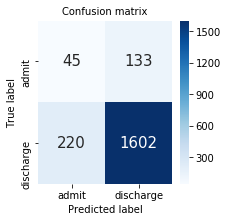

In [238]:
preds, targets = learn.get_preds(DatasetType.Valid) 
predictions = np.argmax(preds, axis = 1)

print ('validation set results')
get_metrics(preds , predictions, show_confusion = True, print_output = True, return_values = False)

training set results
Metrics Report:
---------------
weighted f1:  0.875475094514157
AUROC:        0.7758006568333315
accuracy:     0.866
precision:    [0.345821 0.943814]
recall:       [0.479361 0.906056]
sensitivity:  0.4793608521970706
specificity:  0.9060560077252034
PPV:          0.345821325648415
NPV:          0.9438137663457393


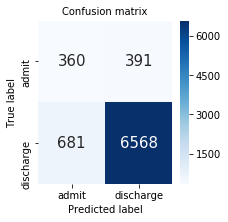

In [239]:
preds, targets = learn.get_preds(DatasetType.Train) 
predictions = np.argmax(preds, axis = 1)

print ('training set results')
get_metrics(preds , predictions, show_confusion = True, print_output = True, return_values = False)

In [242]:
loss_func = nn.CrossEntropyLoss(weight = tensor([1/9,8/9]))
learn = tabular_learner(data, layers, loss_func = loss_func, metrics=[accuracy])
learn.fit_one_cycle(epochs, lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.159883,0.646269,0.911000,00:51
1,0.074908,0.184517,0.900500,00:49
2,0.068472,0.078476,0.911000,00:47
3,0.069665,0.074774,0.911000,00:47
4,0.064383,0.068573,0.911000,00:47
5,0.064636,0.067933,0.910500,00:48
6,0.063377,0.074092,0.911000,00:48
7,0.061776,0.087018,0.908000,00:48
8,0.058938,0.074397,0.908000,00:48
9,0.057977,0.081284,0.905500,00:48


validation set results
Metrics Report:
---------------
weighted f1:  0.8684877388052158
AUROC:        0.6026915107487759
accuracy:     0.9055
precision:    [0.176471 0.91175 ]
recall:       [0.016854 0.992316]
sensitivity:  0.016853932584269662
specificity:  0.9923161361141603
PPV:          0.17647058823529413
NPV:          0.9117498739283914


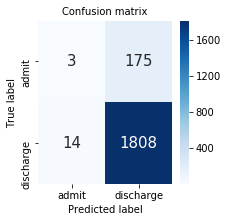

In [243]:
preds, targets = learn.get_preds(DatasetType.Valid) 
predictions = np.argmax(preds, axis = 1)

print ('validation set results')
get_metrics(preds , predictions, show_confusion = True, print_output = True, return_values = False)

training set results
Metrics Report:
---------------
weighted f1:  0.8798736373075625
AUROC:        0.78082334328129
accuracy:     0.914125
precision:    [1.       0.913432]
recall:       [0.08522 1.     ]
sensitivity:  0.085219707057257
specificity:  1.0
PPV:          1.0
NPV:          0.9134324596774194


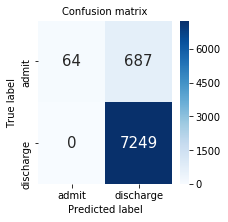

In [244]:
preds, targets = learn.get_preds(DatasetType.Train) 
predictions = np.argmax(preds, axis = 1)

print ('training set results')
get_metrics(preds , predictions, show_confusion = True, print_output = True, return_values = False)

In [170]:
learn = tabular_learner(data, layers, loss_func = LabelSmoothingCrossEntropy(), metrics=[accuracy])
learn.fit_one_cycle(epochs, lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.429397,1.486234,0.132000,00:56
1,0.403334,0.844755,0.908000,00:59
2,0.392112,0.663933,0.908000,00:58
3,0.389618,0.420111,0.906500,01:01
4,0.380528,0.393690,0.908000,00:59
5,0.379854,0.451027,0.889500,01:02
6,0.370681,0.403593,0.899000,01:01
7,0.368719,0.415142,0.893000,00:55
8,0.363264,0.403593,0.900000,00:56
9,0.357988,0.409024,0.897000,00:55


In [178]:
preds, targets = learn.get_preds(DatasetType.Valid) 
predictions = np.argmax(preds, axis = 1)

get_metrics(preds , predictions, show_confusion = True, print_output = True, return_values = False)

In [195]:
preds, targets = learn.get_preds(DatasetType.Train) 
predictions = np.argmax(preds, axis = 1)

get_metrics(preds , predictions, show_confusion = True, print_output = True, return_values = False)

#### 100000 patients, 1000 diagnoses

In [197]:
test_df = small_findings.sample(100000)
cat_names = list(test_df.columns)[:-1]
dep_var = 'discharge'  

#procs = [FillMissing, Categorify, Normalize]
test = TabularList.from_df(test_df.copy(), cat_names=cat_names)

data = (TabularList.from_df(test_df, path=path, cat_names=cat_names, procs=procs)
                           .split_by_rand_pct()
                           .label_from_df(cols=dep_var)
                           .add_test(test)
                           .databunch())

In [199]:
learn = tabular_learner(data, layers, metrics=[accuracy])
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.305677,0.323280,0.900950,08:00
1,0.308844,0.318944,0.896750,08:26
2,0.305925,0.306125,0.899700,08:32
3,0.291029,0.302756,0.900250,08:34
4,0.302242,0.302489,0.900300,08:27


validation set results
Metrics Report:
---------------
weighted f1:  0.8589373678107866
AUROC:        0.6810172392917095
accuracy:     0.9003
precision:    [0.453125 0.90318 ]
recall:       [0.029263 0.996115]
sensitivity:  0.029263370332996974
specificity:  0.9961149961149961
PPV:          0.453125
NPV:          0.9031803542673108


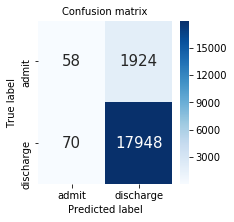

In [200]:
preds, targets = learn.get_preds(DatasetType.Valid) 
predictions = np.argmax(preds, axis = 1)

print ('validation set results')
get_metrics(preds , predictions, show_confusion = True, print_output = True, return_values = False)

training set results
Metrics Report:
---------------
weighted f1:  0.8605585391587469
AUROC:        0.7066838194935212
accuracy:     0.9016625
precision:    [0.520747 0.903971]
recall:       [0.031825 0.996797]
sensitivity:  0.03182452136427032
specificity:  0.9967966940773508
PPV:          0.520746887966805
NPV:          0.9039714278528131


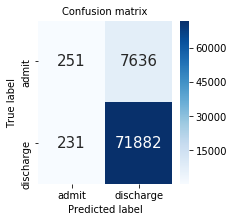

In [201]:
preds, targets = learn.get_preds(DatasetType.Train) 
predictions = np.argmax(preds, axis = 1)

print ('training set results')
get_metrics(preds , predictions, show_confusion = True, print_output = True, return_values = False)

### now xgb?

In [264]:
def get_metrics2(model, y_test, X_test, show_confusion = True, print_output = True, return_values = False):
    preds = model.predict_proba(X_test)
    predictions = model.predict(X_test)
    
    f1_w = sklearn.metrics.f1_score(y_test, predictions, average='weighted')
    f1 = sklearn.metrics.f1_score(y_test, predictions, average=None)
    acc = sklearn.metrics.accuracy_score(y_test, predictions)
    prec = sklearn.metrics.precision_score(y_test,predictions, average=None) 
    rec = sklearn.metrics.recall_score(y_test,predictions, average=None)
    auroc = sklearn.metrics.roc_auc_score(y_test,preds[:,1], average=None)
    confusion = sklearn.metrics.confusion_matrix(y_test, predictions)
    
    tp, fn, fp, tn = confusion[0,0], confusion[0,1], confusion[1,0], confusion[1,1]
    
    sens = tp/(tp + fn)
    spec = tn/(tn + fp)
    ppv = tp/(tp + fp)
    npv = tn/(tn + fn)
    
    
    if print_output:
        print ('Metrics Report:')
        print ('---------------')
        print ('weighted f1: ', f1_w)
        print ('AUROC:       ',auroc)
        print ('accuracy:    ', acc)
        print ('precision:   ', prec)
        print ('recall:      ', rec)
        #print ('admission sens: ', rec[0])
        #print ('admission spec: ', rec[1])
        print ('sensitivity: ', sens)
        print ('specificity: ', spec)
        print ('PPV:         ', ppv)
        print ('NPV:         ', npv)
        
    if show_confusion:
        show_confusion_matrix2(confusion, labels = ['admit', 'd/c'])
     
    if return_values == True:
        return f1_w, auroc, acc, sens, ppv

In [311]:
small_findings, small_array = multihot_encode(diagnoses, split_hist, 1000)

small_findings['target3'] = clin['target3']


There are 1000 diagnoses, 1 unknowns and 165433 patients in the encoded dataframe


In [312]:
test_df = small_findings.sample(100000)
target = test_df.target3.values
test_df.shape

(100000, 1002)

In [313]:
X_train, X_test, y_train, y_test = train_test_split(test_df.iloc[:,:-1], target)

In [314]:
xgc = xgb.XGBClassifier(scale_pos_weight = 1/9, gamma = 0.5, reg_alpha = 0.5)
%time xgc.fit(X_train, y_train)

CPU times: user 4min 40s, sys: 5min 47s, total: 10min 27s
Wall time: 3min 8s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0.5,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.5, reg_lambda=1, scale_pos_weight=0.1111111111111111,
       seed=None, silent=None, subsample=1, verbosity=1)


Training Set


/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Metrics Report:
---------------
weighted f1:  0.6204480764159702
AUROC:        0.6943509729411556
accuracy:     0.5317066666666667
precision:    [0.143913 0.953909]
recall:       [0.772696 0.505796]
sensitivity:  0.7726960582337591
specificity:  0.5057960099824274
PPV:          0.1439132325480265
NPV:          0.9539087086083493


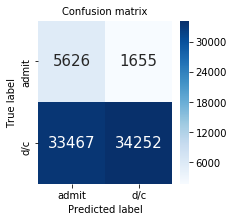


Validation Set


/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Metrics Report:
---------------
weighted f1:  0.616907357771931
AUROC:        0.6911807364305319
accuracy:     0.53092
precision:    [0.151052 0.953206]
recall:       [0.782061 0.502494]
sensitivity:  0.7820613690007868
specificity:  0.5024935435034287
PPV:          0.15105235164501177
NPV:          0.9532055072218938


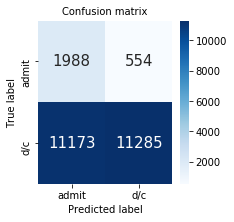

In [315]:
print ('\nTraining Set')
train_f1, train_auroc, train_acc, train_sens, train_ppv = get_metrics2(xgc, y_train, X_train, return_values = True)
print ('\nValidation Set')
test_f1, test_auroc, test_acc, test_sens, test_ppv = get_metrics2(xgc, y_test, X_test, return_values = True)

In [316]:
small_findings, small_array = multihot_encode(diagnoses, split_hist, 5000)

small_findings['target3'] = clin['target3']


There are 5000 diagnoses, 1 unknowns and 165433 patients in the encoded dataframe


In [317]:
test_df = small_findings.sample(100000)
target = test_df.target3.values
test_df.shape

(100000, 5002)

In [325]:
data = test_df.iloc[:,:-1].values

In [326]:
X_train, X_test, y_train, y_test = train_test_split(data, target)

In [327]:
xgc = xgb.XGBClassifier(scale_pos_weight = 1/9, gamma = 0.5, reg_alpha = 0.5)
%time xgc.fit(X_train, y_train)

CPU times: user 23min 36s, sys: 30min 7s, total: 53min 43s
Wall time: 15min 11s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0.5,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.5, reg_lambda=1, scale_pos_weight=0.1111111111111111,
       seed=None, silent=None, subsample=1, verbosity=1)


Training Set


/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Metrics Report:
---------------
weighted f1:  0.62225845365602
AUROC:        0.6957094529332346
accuracy:     0.5344666666666666
precision:    [0.146303 0.953475]
recall:       [0.772444 0.508517]
sensitivity:  0.7724437211825332
specificity:  0.5085174341229705
PPV:          0.14630262245395936
NPV:          0.9534754761970776


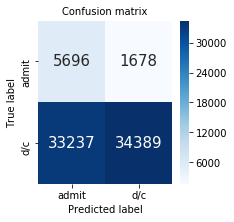


Validation Set


/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Metrics Report:
---------------
weighted f1:  0.6191280071964504
AUROC:        0.6902107050161823
accuracy:     0.53076
precision:    [0.144477 0.952871]
recall:       [0.77011  0.504767]
sensitivity:  0.7701102490812577
specificity:  0.5047669726397942
PPV:          0.14447678872376282
NPV:          0.9528712539762264


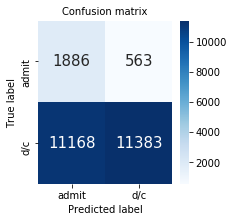

In [328]:
print ('\nTraining Set')
train_f1, train_auroc, train_acc, train_sens, train_ppv = get_metrics2(xgc, y_train, X_train, return_values = True)
print ('\nValidation Set')
test_f1, test_auroc, test_acc, test_sens, test_ppv = get_metrics2(xgc, y_test, X_test, return_values = True)

### experimentation with word2vec

In [ ]:
!conda install -c conda-forge gensim

Solving environment: done

## Package Plan ##

  environment location: /Users/jjaskolkambp/anaconda3

  added / updated specs:
    - gensim


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2018.4.16          |           py36_0         142 KB  conda-forge
    conda-4.8.3                |   py36h9f0ad1d_1         3.0 MB  conda-forge
    gensim-3.8.0               |   py36h6440ff4_0        22.7 MB
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    ------------------------------------------------------------
                                           Total:        25.9 MB

The following NEW packages will be INSTALLED:

  python_abi         conda-forge/osx-64::python_abi-3.6-1_cp36m

The following packages will be UPDATED:

  conda                       pkgs/main::conda-4.8.3-py36_0 --> conda-forge::conda-4.8.3-py36h9f0ad1d_1
  gensim                   

In [ ]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import gensim.downloader as api

#### model 1

In [294]:
#build and train a word2vec model with the split history   #note the parameters
model = Word2Vec(split_hist, min_count=1,size= 300,workers=3, window =3, sg = 1)

In [296]:
splithx_words = sorted(list(model.wv.vocab))

c_words = [word for word in splithx_words if word[0] == 'c']; print ('c_words: ',len(c_words))
h_words = [word for word in splithx_words if word[0] == 'h']; print ('h_words: ', len(h_words))
r_words = [word for word in splithx_words if word[0] == 'r']; print ('r_words: ', len(r_words))

c_words:  2446
h_words:  1754
r_words:  1144


In [302]:
#all terrible

print (model.wv.similarity('ca right breast', 'ca right breat'))
print (model.wv.similarity('ca right breast', 'h pylori'))
print (model.wv.similarity('ca right breast', 'h1n1'))
print (model.wv.similarity('ca right breast', 'h-pylori'))
print (model.wv.similarity('h pylori', 'h-pylori'))

-0.03592796
0.98685867
0.9855157
0.99560785
0.9886368


In [303]:
h_score = 0
for word in h_words:
    h_score += model.wv.similarity(h_words[0], word)
    print('%r\t%r\t%.2f' % (h_words[0], word, model.wv.similarity(h_words[0], word)))

mean_hscore = h_score/len(h_words)

'h - pylori'	'h - pylori'	1.00
'h - pylori'	'h piloro'	-0.07
'h - pylori'	'h plyori'	-0.04
'h - pylori'	'h pylori'	-0.04
'h - pylori'	'h pylori infection'	-0.04
'h - pylori'	'h pyloric'	-0.04
'h - pylori'	'h pylorie'	-0.04
'h - pylori'	'h- pylori'	-0.05
'h - pylori'	'h- pyloric'	-0.04
'h - pylori'	'h-plyorie'	-0.05
'h - pylori'	'h-pylori'	-0.04
'h - pylori'	'h-pylori completed tx'	-0.04
'h - pylori'	'h-pyloric'	-0.04
'h - pylori'	'h-pylorie'	-0.05
'h - pylori'	'h/o allergic rxns'	-0.04
'h - pylori'	'h/o herneactomy 2014'	0.05
'h - pylori'	'h/o influenza a'	-0.03
'h - pylori'	'h/o low bp'	0.02
'h - pylori'	'h1n1'	-0.05
'h - pylori'	'ha d/t tumor'	-0.04
'h - pylori'	'haalluciations'	-0.04
'h - pylori'	'had 1 seizure in 1995'	-0.02
'h - pylori'	'had 1 stent'	-0.03
'h - pylori'	'had 1 stent -inserted july 22'	-0.04
'h - pylori'	'had 1 stent 2007'	-0.03
'h - pylori'	'had 1 stent 3years ago'	-0.03
'h - pylori'	'had 2 stent'	-0.03
'h - pylori'	'had 2 stent -may24'	-0.04
'h - pylori'	'had 2 st

'h - pylori'	'hight chol'	-0.04
'h - pylori'	'hight cholesterol'	-0.04
'h - pylori'	'highten q-tc interval rate'	-0.02
'h - pylori'	'hign cholesterol'	-0.03
'h - pylori'	'hih cholesterol'	0.01
'h - pylori'	'hihg bp'	-0.03
'h - pylori'	'hip'	-0.04
'h - pylori'	'hip #'	-0.04
'h - pylori'	'hip abscess/feverxadmittedx1 month-discharge last sat'	-0.04
'h - pylori'	'hip and brain'	-0.05
'h - pylori'	'hip and knee replacement'	-0.02
'h - pylori'	'hip and knee replacement bilat'	-0.03
'h - pylori'	'hip and left wrist fracture'	-0.04
'h - pylori'	'hip avn'	-0.03
'h - pylori'	'hip bone ca'	-0.04
'h - pylori'	'hip c'	-0.03
'h - pylori'	'hip clunk'	-0.04
'h - pylori'	'hip deformities'	-0.04
'h - pylori'	'hip dysplasia'	-0.04
'h - pylori'	'hip dysplasia surgery'	0.00
'h - pylori'	'hip fracture'	-0.04
'h - pylori'	'hip fracture 2 years ago'	-0.04
'h - pylori'	'hip fracture bilateral'	-0.06
'h - pylori'	'hip fracture surgery done sept 20018'	-0.04
'h - pylori'	'hip fx'	-0.04
'h - pylori'	'hip injury'

In [304]:
c_score = 0
for word in c_words:
    c_score += model.wv.similarity(c_words[0], word)
    print('%r\t%r\t%.2f' % (c_words[0], word, model.wv.similarity(c_words[0], word)))

mean_cscore = c_score/len(c_words)

'c -section'	'c -section'	1.00
'c -section'	'c -section - at 37 weeks - twin'	-0.02
'c -section'	'c cesection'	0.99
'c -section'	'c dif'	0.99
'c -section'	'c diff'	0.99
'c -section'	'c diff 2017'	0.98
'c -section'	'c diff 5years ago'	0.97
'c -section'	'c diff x2'	0.98
'c -section'	'c pap'	0.99
'c -section'	'c section'	0.98
'c -section'	'c section 1 wk ago'	0.70
'c -section'	'c section 2016'	0.99
'c -section'	'c section 37 wks'	0.01
'c -section'	'c section 4 weeks ago'	0.97
'c -section'	'c section 41 wks gest'	0.03
'c -section'	'c section at birth'	0.94
'c -section'	'c section aug 23'	0.08
'c -section'	'c section birth'	0.99
'c -section'	'c section born'	0.99
'c -section'	'c section born 38 wks and no complication'	-0.01
'c -section'	'c section dec 2017'	0.99
'c -section'	'c section delivery'	-0.00
'c -section'	'c section due to decels'	0.99
'c -section'	'c section due to elevated heart beat 220 blood pressure'	0.99
'c -section'	'c section due to prolonged labour and fever'	-0.08
'c -se

'c -section'	'choly 2015'	-0.08
'c -section'	'cholycysectomy'	0.99
'c -section'	'cholycystectomy'	-0.04
'c -section'	'cholycystectomy 2017'	0.99
'c -section'	'cholycystectomy 3 weeks ago'	0.05
'c -section'	'cholycystectomy breast reduction'	-0.00
'c -section'	'choresterol'	0.91
'c -section'	'chormasone 5'	0.08
'c -section'	'chornic back and knee pain'	0.99
'c -section'	'chornic back pain'	0.99
'c -section'	'choronic back pain'	0.09
'c -section'	'choronic drinker'	-0.00
'c -section'	'choronic kidney diseae'	0.99
'c -section'	"chrn's disease"	0.99
'c -section'	'chrnic back pain'	0.97
'c -section'	'chrnic kidney inflammation'	0.99
'c -section'	"chrohn's"	0.95
'c -section'	"chrohn's disease"	0.99
'c -section'	'chrohns'	0.95
'c -section'	'chrohns disease'	0.99
'c -section'	'chroic back pain'	0.89
'c -section'	'chroinic back pain'	0.98
'c -section'	'chromic back pain'	0.34
'c -section'	'chromosoaml problem'	0.96
'c -section'	'chromosome 15 disorder'	0.03
'c -section'	'chromosome 22 q11'	0.98

'c -section'	'currently being assessed for delirium'	0.99
'c -section'	'currently dx with bld clot in the lung'	-0.05
'c -section'	'currently getting cardiac investigations'	0.98
'c -section'	'currently on antibiotics for throat infection'	0.97
'c -section'	'currently on chemo'	0.99
'c -section'	'currently wearing a holter monitor'	0.99
'c -section'	'curretn pneumonia'	0.98
'c -section'	'curvature problems in vertebral disc'	0.96
'c -section'	'cushing diaease'	0.98
'c -section'	'cushing disease'	-0.03
'c -section'	'cushings'	0.68
'c -section'	'cushings disease'	0.99
'c -section'	'cushion syndrome'	0.98
'c -section'	'cut cornea'	0.99
'c -section'	'cut fallopian tubes'	0.99
'c -section'	'cutting'	0.98
'c -section'	'cutting self'	0.81
'c -section'	'cva'	0.79
'c -section'	'cva (10 years ago'	0.99
'c -section'	'cva (1996'	0.99
'c -section'	'cva (2008'	0.98
'c -section'	'cva (2014'	0.99
'c -section'	'cva (2017'	0.99
'c -section'	'cva (dec 2018'	0.98
'c -section'	'cva (may 2018 resulting in r

In [305]:
r_score = 0
for word in r_words:
    r_score += model.wv.similarity(r_words[0], word)
    print('%r\t%r\t%.2f' % (r_words[0], word, model.wv.similarity(r_words[0], word)))

mean_rscore = r_score/len(r_words)

'rabdomyelosis'	'rabdomyelosis'	1.00
'rabdomyelosis'	'rabdomyocarcoma'	0.08
'rabdomyelosis'	'rabeprazole'	0.06
'rabdomyelosis'	'rabeprazole 20mg by mouth q daily with naproxen'	0.06
'rabdomyelosis'	'raberpazole'	0.07
'rabdomyelosis'	'rad'	0.07
'rabdomyelosis'	'rad prostatectomy in 1987'	0.07
'rabdomyelosis'	'radaition 2017'	0.06
'rabdomyelosis'	'radiacal prostectomy'	0.07
'rabdomyelosis'	'radial prostatectomy'	0.10
'rabdomyelosis'	'radiation'	0.07
'rabdomyelosis'	'radiation - no surgery'	0.05
'rabdomyelosis'	'radiation 2013'	0.06
'rabdomyelosis'	'radiation 2016'	0.06
'rabdomyelosis'	'radiation and chemo completed'	0.02
'rabdomyelosis'	'radiation and chemo on november 15 th'	0.07
'rabdomyelosis'	'radiation aug 2018'	0.06
'rabdomyelosis'	'radiation completed in the last couple of days'	0.07
'rabdomyelosis'	'radiation completed sep 2018)'	0.06
'rabdomyelosis'	'radiation done'	0.06
'rabdomyelosis'	'radiation done 2 years ago'	0.07
'rabdomyelosis'	'radiation done in october'	0.06
'rabdomyel

'rabdomyelosis'	'right frozen shoulder'	0.05
'rabdomyelosis'	'right groin <lf>chronic back pain'	0.06
'rabdomyelosis'	'right groin hernia'	0.05
'rabdomyelosis'	'right groinal hernia'	0.06
'rabdomyelosis'	'right hamstring tear'	0.00
'rabdomyelosis'	'right hand amputee'	0.07
'rabdomyelosis'	'right hand fracture'	-0.04
'rabdomyelosis'	'right hand injury 1997-98'	-0.06
'rabdomyelosis'	'right hearing impairment'	0.06
'rabdomyelosis'	'right hearing loss'	-0.01
'rabdomyelosis'	'right heel ulcer'	0.06
'rabdomyelosis'	'right hemiclitomy 2015'	0.06
'rabdomyelosis'	'right hemicolectomy'	0.07
'rabdomyelosis'	'right hemithyroidectomy'	0.05
'rabdomyelosis'	'right hernia surgery'	-0.03
'rabdomyelosis'	'right hhip replacement x 2'	0.04
'rabdomyelosis'	'right hip #'	0.06
'rabdomyelosis'	'right hip and right knee replacement'	0.04
'rabdomyelosis'	'right hip arthritis'	-0.00
'rabdomyelosis'	'right hip arthroplasty'	0.06
'rabdomyelosis'	'right hip arthroplasty x 8years ago'	0.06
'rabdomyelosis'	'right hip

'rabdomyelosis'	'right shoulder tender tear'	0.07
'rabdomyelosis'	'right shouler sx'	0.08
'rabdomyelosis'	'right side above knee amputation'	-0.03
'rabdomyelosis'	'right side breast cancer'	0.13
'rabdomyelosis'	'right side ca breast 2004'	0.06
'rabdomyelosis'	'right side chf'	0.07
'rabdomyelosis'	'right side crush injury'	0.06
'rabdomyelosis'	'right side hypertrophy'	0.05
'rabdomyelosis'	'right side kidney stones'	-0.05
'rabdomyelosis'	'right side limp arm'	-0.08
'rabdomyelosis'	'right side mastectomy'	0.07
'rabdomyelosis'	'right side numbness'	0.04
'rabdomyelosis'	'right side paralysis'	0.06
'rabdomyelosis'	'right side sciatic nerve pinch'	0.06
'rabdomyelosis'	'right side weakness from previous cva'	0.04
'rabdomyelosis'	'right sided breast cancer'	0.05
'rabdomyelosis'	'right sided defcits from cervical sx'	0.08
'rabdomyelosis'	'right sided deficit'	0.07
'rabdomyelosis'	'right sided deficit from cva'	0.06
'rabdomyelosis'	'right sided deficit from previous stroke'	0.07
'rabdomyelosis'	'

In [306]:
#need a simple metric to see how model does with minor changes
print (mean_cscore, mean_hscore, mean_rscore)

0.7451523738458623 -0.027151701303624605 0.045461690524067705


#### model 2

In [307]:
model = Word2Vec(split_hist, min_count=1,size= 300,workers=3, window = 5, sg = 1)

In [308]:
splithx_words = sorted(list(model.wv.vocab))

c_words = [word for word in splithx_words if word[0] == 'c']; print ('c_words: ',len(c_words))
h_words = [word for word in splithx_words if word[0] == 'h']; print ('h_words: ', len(h_words))
r_words = [word for word in splithx_words if word[0] == 'r']; print ('r_words: ', len(r_words))

c_words:  2446
h_words:  1754
r_words:  1144


In [309]:
c_score = 0
for word in c_words:
    c_score += model.wv.similarity(c_words[0], word)
    print('%r\t%r\t%.2f' % (c_words[0], word, model.wv.similarity(c_words[0], word)))

mean_cscore = c_score/len(c_words)

'c -section'	'c -section'	1.00
'c -section'	'c -section - at 37 weeks - twin'	-0.02
'c -section'	'c cesection'	0.99
'c -section'	'c dif'	1.00
'c -section'	'c diff'	0.99
'c -section'	'c diff 2017'	0.97
'c -section'	'c diff 5years ago'	0.98
'c -section'	'c diff x2'	0.97
'c -section'	'c pap'	0.99
'c -section'	'c section'	0.99
'c -section'	'c section 1 wk ago'	0.76
'c -section'	'c section 2016'	0.95
'c -section'	'c section 37 wks'	-0.00
'c -section'	'c section 4 weeks ago'	0.99
'c -section'	'c section 41 wks gest'	0.03
'c -section'	'c section at birth'	0.98
'c -section'	'c section aug 23'	0.07
'c -section'	'c section birth'	0.99
'c -section'	'c section born'	1.00
'c -section'	'c section born 38 wks and no complication'	-0.04
'c -section'	'c section dec 2017'	0.99
'c -section'	'c section delivery'	0.00
'c -section'	'c section due to decels'	0.99
'c -section'	'c section due to elevated heart beat 220 blood pressure'	0.99
'c -section'	'c section due to prolonged labour and fever'	-0.07
'c -se

'c -section'	'chf/afib/hypothyroid/'	0.06
'c -section'	'chf/copd/gout/osteoarthritis/hypertension/afib/anxiety/pvd/nephrectomy'	-0.07
'c -section'	'chf/dementia/cholesterol/hypertension/thyroid/growth  skin ca'	0.00
'c -section'	'chf<left niddm'	0.97
'c -section'	'chg/anxiety/mi'	-0.02
'c -section'	'chhol'	0.99
'c -section'	'chiari'	0.92
'c -section'	'chiari malformation'	0.49
'c -section'	'chiari malformation syndrome'	0.98
'c -section'	'chiaria one malformation'	1.00
'c -section'	'chicken pox'	0.99
'c -section'	'chicken pox 1 month ago'	0.13
'c -section'	'chicken pox as a child'	0.95
'c -section'	'chicken pox at 9 year old'	0.03
'c -section'	'chickenpox'	-0.04
'c -section'	'chigh chol'	0.86
'c -section'	'chikingunya'	0.99
'c -section'	'child astma'	0.92
'c -section'	'child born at 40 weeks'	-0.05
'c -section'	'child is a twin'	0.98
'c -section'	'child is in the care of aunt - due to substance withdrawal'	0.05
'c -section'	'child is premature at 34 weeks delivery'	-0.05
'c -section'	'

'c -section'	'coronary stent'	0.99
'c -section'	'corticobasal syndrome'	0.98
'c -section'	'cortisol replacement since 3 month'	0.06
'c -section'	'cosft'	0.99
'c -section'	'cosntipation'	0.99
'c -section'	'costal joints swelling'	1.00
'c -section'	'costcochondritis'	0.97
'c -section'	'costiocongitis'	-0.01
'c -section'	'costipation'	0.99
'c -section'	'costo-condritis'	0.99
'c -section'	'costochondriittis'	0.96
'c -section'	'costochondritis'	1.00
'c -section'	'cough'	0.98
'c -section'	'cough and cold'	-0.04
'c -section'	'cough starts last night'	0.10
'c -section'	'cough syrup'	0.44
'c -section'	'cough x 6 days'	0.98
'c -section'	'cough x8 months'	0.98
'c -section'	'cough- asthma'	0.98
'c -section'	'cough/cold  infections'	-0.08
'c -section'	'could not obtain'	-0.03
'c -section'	'could not obtain--family did not know history'	-0.76
'c -section'	'could not obtain--family does not know'	0.02
'c -section'	'could not obtain--patient left to washroom suddenly'	0.02
'c -section'	'could not obta

In [310]:
h_score = 0
for word in h_words:
    h_score += model.wv.similarity(h_words[0], word)
    print('%r\t%r\t%.2f' % (h_words[0], word, model.wv.similarity(h_words[0], word)))

mean_hscore = h_score/len(h_words)

'h - pylori'	'h - pylori'	1.00
'h - pylori'	'h piloro'	-0.07
'h - pylori'	'h plyori'	-0.04
'h - pylori'	'h pylori'	-0.04
'h - pylori'	'h pylori infection'	-0.07
'h - pylori'	'h pyloric'	-0.05
'h - pylori'	'h pylorie'	-0.05
'h - pylori'	'h- pylori'	-0.04
'h - pylori'	'h- pyloric'	-0.05
'h - pylori'	'h-plyorie'	-0.05
'h - pylori'	'h-pylori'	-0.05
'h - pylori'	'h-pylori completed tx'	-0.05
'h - pylori'	'h-pyloric'	-0.04
'h - pylori'	'h-pylorie'	-0.05
'h - pylori'	'h/o allergic rxns'	-0.03
'h - pylori'	'h/o herneactomy 2014'	0.05
'h - pylori'	'h/o influenza a'	-0.05
'h - pylori'	'h/o low bp'	-0.00
'h - pylori'	'h1n1'	-0.07
'h - pylori'	'ha d/t tumor'	-0.05
'h - pylori'	'haalluciations'	-0.05
'h - pylori'	'had 1 seizure in 1995'	-0.03
'h - pylori'	'had 1 stent'	-0.05
'h - pylori'	'had 1 stent -inserted july 22'	-0.05
'h - pylori'	'had 1 stent 2007'	-0.04
'h - pylori'	'had 1 stent 3years ago'	-0.05
'h - pylori'	'had 2 stent'	-0.04
'h - pylori'	'had 2 stent -may24'	-0.05
'h - pylori'	'had 2 s

'h - pylori'	'heart valve replaced - 2016'	-0.05
'h - pylori'	'heart valve replaced 11 years ago; high blood pressure'	-0.04
'h - pylori'	'heart valve replaced 17 years ago'	-0.06
'h - pylori'	'heart valve replacement'	-0.04
'h - pylori'	'heart valve replacement 2017'	0.03
'h - pylori'	'heart valve stenosis'	-0.04
'h - pylori'	'heart valve surgery'	-0.04
'h - pylori'	'heart valve surgery 1993'	0.06
'h - pylori'	'heart valve surgery 2012'	-0.02
'h - pylori'	'heart valve surgery 2017'	-0.04
'h - pylori'	'heart valve surgery jan 2019'	-0.04
'h - pylori'	'heart valve sx'	-0.05
'h - pylori'	'heart valve weak'	-0.05
'h - pylori'	'heart valve x 2 insuficiency'	-0.05
'h - pylori'	'heart valves x 2'	-0.05
'h - pylori'	'heart vavlve replacement'	-0.05
'h - pylori'	'heart vavlve replacement 2007'	-0.04
'h - pylori'	'heart with blockages'	-0.05
'h - pylori'	'heart: mitral valve prolapse'	-0.05
'h - pylori'	'heartattack 10years'	-0.06
'h - pylori'	'heartburn'	-0.04
'h - pylori'	'hearty valve weak'	

'h - pylori'	'high cholesteroll'	-0.05
'h - pylori'	'high cholesterolniddm'	-0.04
'h - pylori'	'high cholesterols'	-0.03
'h - pylori'	'high cholesterrol'	-0.05
'h - pylori'	'high cholestrerol'	-0.04
'h - pylori'	'high cholestritis'	-0.05
'h - pylori'	'high cholestrol'	-0.01
'h - pylori'	'high cholestrolant medical history'	-0.05
'h - pylori'	'high cholestyrol'	-0.05
'h - pylori'	'high choleterol'	-0.03
'h - pylori'	'high choletrol'	-0.05
'h - pylori'	'high choletserol'	-0.03
'h - pylori'	'high cholhtn'	-0.03
'h - pylori'	'high choloesterol'	-0.05
'h - pylori'	'high cholosterol'	-0.05
'h - pylori'	'high cholseterol'	-0.05
'h - pylori'	'high cholsterol'	-0.05
'h - pylori'	'high choltesterol'	-0.04
'h - pylori'	'high choresterol'	-0.04
'h - pylori'	'high chpolesterol htn'	-0.04
'h - pylori'	'high cjholesterol'	-0.04
'h - pylori'	'high ck'	-0.05
'h - pylori'	'high colestrol'	-0.05
'h - pylori'	'high cortisol'	-0.03
'h - pylori'	'high creatine'	-0.04
'h - pylori'	'high creatinin'	0.08
'h - 

'h - pylori'	'horseshoe kidney'	-0.05
'h - pylori'	'horseshoe kidneys'	-0.05
'h - pylori'	'hospital admission for croup'	-0.04
'h - pylori'	'hospital admission for pancreatitis'	-0.06
'h - pylori'	'hospital admission for shoulder pain'	-0.05
'h - pylori'	'hospital admission for urinary tract infection'	-0.05
'h - pylori'	'hospital visit for dysuria'	-0.05
'h - pylori'	'hospitalization for respiratory issues'	-0.06
'h - pylori'	'hospitalization post-birth in nicu'	0.02
'h - pylori'	'hospitalized 11 days due to low blood sugar'	-0.05
'h - pylori'	'hospitalized at 3 weeks old for bronchiolitis'	0.07
'h - pylori'	'hospitalized for spider bite at age 3'	-0.07
'h - pylori'	'hospitalized in june for fever and swollen neck lymph nodes'	0.09
'h - pylori'	'hospitalized post birth 1'	-0.05
'h - pylori'	'hospitlizesd at least once q 6 weeks'	-0.05
'h - pylori'	'hot flash'	-0.05
'h - pylori'	'hot flashes'	-0.04
'h - pylori'	'hot flashes \\t\\ constant sweating'	-0.05
'h - pylori'	'hot flashes/night

In [311]:
r_score = 0
for word in r_words:
    r_score += model.wv.similarity(r_words[0], word)
    print('%r\t%r\t%.2f' % (r_words[0], word, model.wv.similarity(r_words[0], word)))

mean_rscore = r_score/len(r_words)

'rabdomyelosis'	'rabdomyelosis'	1.00
'rabdomyelosis'	'rabdomyocarcoma'	0.03
'rabdomyelosis'	'rabeprazole'	0.04
'rabdomyelosis'	'rabeprazole 20mg by mouth q daily with naproxen'	0.02
'rabdomyelosis'	'raberpazole'	0.04
'rabdomyelosis'	'rad'	0.03
'rabdomyelosis'	'rad prostatectomy in 1987'	0.03
'rabdomyelosis'	'radaition 2017'	0.03
'rabdomyelosis'	'radiacal prostectomy'	0.05
'rabdomyelosis'	'radial prostatectomy'	0.04
'rabdomyelosis'	'radiation'	0.04
'rabdomyelosis'	'radiation - no surgery'	0.04
'rabdomyelosis'	'radiation 2013'	0.04
'rabdomyelosis'	'radiation 2016'	0.04
'rabdomyelosis'	'radiation and chemo completed'	0.03
'rabdomyelosis'	'radiation and chemo on november 15 th'	0.05
'rabdomyelosis'	'radiation aug 2018'	0.03
'rabdomyelosis'	'radiation completed in the last couple of days'	0.03
'rabdomyelosis'	'radiation completed sep 2018)'	0.03
'rabdomyelosis'	'radiation done'	0.02
'rabdomyelosis'	'radiation done 2 years ago'	0.02
'rabdomyelosis'	'radiation done in october'	0.07
'rabdomyel

In [312]:
#need a simple metric to see how model does with minor changes
print (mean_cscore, mean_hscore, mean_rscore)

0.7482947178198205 -0.033062409522062186 0.02407109001136747


#### model 3

In [313]:
model = Word2Vec(split_hist, min_count=1,size= 300,workers=3, window = 7, sg = 1)

In [314]:
splithx_words = sorted(list(model.wv.vocab))

c_words = [word for word in splithx_words if word[0] == 'c']; print ('c_words: ',len(c_words))
h_words = [word for word in splithx_words if word[0] == 'h']; print ('h_words: ', len(h_words))
r_words = [word for word in splithx_words if word[0] == 'r']; print ('r_words: ', len(r_words))

c_words:  2446
h_words:  1754
r_words:  1144


In [315]:
c_score = 0
for word in c_words:
    c_score += model.wv.similarity(c_words[0], word)
    print('%r\t%r\t%.2f' % (c_words[0], word, model.wv.similarity(c_words[0], word)))

mean_cscore = c_score/len(c_words)

'c -section'	'c -section'	1.00
'c -section'	'c -section - at 37 weeks - twin'	-0.02
'c -section'	'c cesection'	0.98
'c -section'	'c dif'	0.98
'c -section'	'c diff'	0.99
'c -section'	'c diff 2017'	0.99
'c -section'	'c diff 5years ago'	0.98
'c -section'	'c diff x2'	0.94
'c -section'	'c pap'	0.99
'c -section'	'c section'	0.99
'c -section'	'c section 1 wk ago'	0.48
'c -section'	'c section 2016'	0.99
'c -section'	'c section 37 wks'	-0.01
'c -section'	'c section 4 weeks ago'	0.98
'c -section'	'c section 41 wks gest'	0.02
'c -section'	'c section at birth'	0.98
'c -section'	'c section aug 23'	0.06
'c -section'	'c section birth'	0.99
'c -section'	'c section born'	0.99
'c -section'	'c section born 38 wks and no complication'	-0.04
'c -section'	'c section dec 2017'	0.97
'c -section'	'c section delivery'	0.03
'c -section'	'c section due to decels'	0.98
'c -section'	'c section due to elevated heart beat 220 blood pressure'	0.98
'c -section'	'c section due to prolonged labour and fever'	-0.05
'c -se

'c -section'	'cholestril'	0.93
'c -section'	'cholestrion'	0.95
'c -section'	'cholestrol'	0.67
'c -section'	'cholestrolniddm'	0.98
'c -section'	'choleterol'	0.97
'c -section'	'choletitiest'	0.99
'c -section'	'cholitis'	0.01
'c -section'	'cholitits'	0.03
'c -section'	'choll'	0.96
'c -section'	'chollesterol'	0.91
'c -section'	'cholocystectomy'	0.99
'c -section'	'cholosterol'	0.88
'c -section'	'cholostomy or iileostomy'	-0.07
'c -section'	'chols'	0.96
'c -section'	'cholscstectomy'	-0.03
'c -section'	'cholserol'	0.99
'c -section'	'cholsetrol'	0.93
'c -section'	'cholsettol'	0.97
'c -section'	'cholsterol'	0.95
'c -section'	'choly'	0.99
'c -section'	'choly 2 years ago'	0.95
'c -section'	'choly 2015'	-0.07
'c -section'	'cholycysectomy'	0.99
'c -section'	'cholycystectomy'	0.01
'c -section'	'cholycystectomy 2017'	0.99
'c -section'	'cholycystectomy 3 weeks ago'	0.04
'c -section'	'cholycystectomy breast reduction'	-0.02
'c -section'	'choresterol'	0.22
'c -section'	'chormasone 5'	0.06
'c -section'	'

'c -section'	'ct showed - small brain aneurysm'	0.99
'c -section'	'culdoplasty'	0.97
'c -section'	'cured'	0.98
'c -section'	'curent typhoid'	-0.00
'c -section'	'current bed sore'	0.94
'c -section'	'current blood clot to right leg'	0.50
'c -section'	'current cellulitis to leg'	0.86
'c -section'	'current ear infection'	-0.01
'c -section'	'current eye infection'	-0.02
'c -section'	'current investigations for left lower quadrant abdo pain'	0.25
'c -section'	'current ivf treatment--last on sat'	-0.89
'c -section'	'current left wrist fracture'	-0.00
'c -section'	'current pneumonia'	0.98
'c -section'	'current tb'	0.94
'c -section'	'current throat infection'	0.07
'c -section'	'current tonsilitis'	-0.05
'c -section'	'current tooth infection- on antibiotics'	0.96
'c -section'	'current urinary tract infection'	0.97
'c -section'	'current urinary tract infection being treated by family md'	0.99
'c -section'	'current wound to left leg'	0.89
'c -section'	'currently 16 weeks pregnant'	-0.02
'c -sectio

In [316]:
h_score = 0
for word in h_words:
    h_score += model.wv.similarity(h_words[0], word)
    print('%r\t%r\t%.2f' % (h_words[0], word, model.wv.similarity(h_words[0], word)))

mean_hscore = h_score/len(h_words)

'h - pylori'	'h - pylori'	1.00
'h - pylori'	'h piloro'	-0.07
'h - pylori'	'h plyori'	-0.03
'h - pylori'	'h pylori'	-0.03
'h - pylori'	'h pylori infection'	-0.03
'h - pylori'	'h pyloric'	-0.05
'h - pylori'	'h pylorie'	-0.03
'h - pylori'	'h- pylori'	-0.04
'h - pylori'	'h- pyloric'	-0.03
'h - pylori'	'h-plyorie'	-0.05
'h - pylori'	'h-pylori'	-0.03
'h - pylori'	'h-pylori completed tx'	-0.03
'h - pylori'	'h-pyloric'	-0.04
'h - pylori'	'h-pylorie'	-0.05
'h - pylori'	'h/o allergic rxns'	0.00
'h - pylori'	'h/o herneactomy 2014'	0.05
'h - pylori'	'h/o influenza a'	-0.03
'h - pylori'	'h/o low bp'	-0.00
'h - pylori'	'h1n1'	-0.04
'h - pylori'	'ha d/t tumor'	-0.02
'h - pylori'	'haalluciations'	-0.04
'h - pylori'	'had 1 seizure in 1995'	0.05
'h - pylori'	'had 1 stent'	-0.03
'h - pylori'	'had 1 stent -inserted july 22'	-0.03
'h - pylori'	'had 1 stent 2007'	-0.04
'h - pylori'	'had 1 stent 3years ago'	-0.02
'h - pylori'	'had 2 stent'	-0.02
'h - pylori'	'had 2 stent -may24'	-0.03
'h - pylori'	'had 2 ste

'h - pylori'	'hemorhoids'	-0.03
'h - pylori'	'hemorhroids'	0.06
'h - pylori'	'hemoroids'	-0.04
'h - pylori'	'hemorrhagic cyst to right ovary'	-0.05
'h - pylori'	'hemorrhagic stroke'	-0.03
'h - pylori'	'hemorrhagic stroke last april'	-0.04
'h - pylori'	'hemorrhiods'	-0.02
'h - pylori'	'hemorrhoid'	-0.03
'h - pylori'	'hemorrhoid surgery'	-0.04
'h - pylori'	'hemorrhoid surgery ( dec 4th'	-0.03
'h - pylori'	'hemorrhoid sx'	-0.02
'h - pylori'	'hemorrhoidectomy'	-0.03
'h - pylori'	'hemorrhoidectomy x 3 - last january 9th'	-0.03
'h - pylori'	'hemorrhoidectopmy'	-0.04
'h - pylori'	'hemorrhoids'	-0.02
'h - pylori'	'hemorrhoids 2 yr ago'	-0.01
'h - pylori'	'hemorrhoids removed 2 weeks ago'	-0.05
'h - pylori'	'hemorrhoids sx 1987'	-0.04
'h - pylori'	'hemorrhoids x 10 years ago'	-0.04
'h - pylori'	'hemorrhords'	-0.03
'h - pylori'	'hemorrihoids'	-0.03
'h - pylori'	'hemorriods'	-0.03
'h - pylori'	'hemorroid'	-0.03
'h - pylori'	'hemorroid repairs'	0.02
'h - pylori'	'hemorroids'	-0.03
'h - pylori'	'he

'h - pylori'	'hypothryroid'	-0.04
'h - pylori'	'hypothydorism'	-0.03
'h - pylori'	'hypothyredectomy'	-0.03
'h - pylori'	'hypothyrid'	-0.04
'h - pylori'	'hypothyridism'	-0.03
'h - pylori'	'hypothyrodism'	-0.04
'h - pylori'	'hypothyroid'	-0.00
'h - pylori'	'hypothyroid and gerd'	-0.02
'h - pylori'	'hypothyroid and htn'	-0.04
'h - pylori'	'hypothyroidim'	-0.04
'h - pylori'	'hypothyroidis'	-0.03
'h - pylori'	'hypothyroidism'	-0.01
'h - pylori'	'hypothyroidisn'	-0.03
'h - pylori'	'hypothyroidsim'	-0.04
'h - pylori'	'hypothyroidsm'	-0.03
'h - pylori'	'hypothyroism'	-0.05
'h - pylori'	'hypotonia'	-0.03
'h - pylori'	'hypotyhroid'	-0.02
'h - pylori'	'hypoxemia'	-0.03
'h - pylori'	'hypremesis'	-0.02
'h - pylori'	'hypsterectomy-tumor'	-0.11
'h - pylori'	'hyptension'	-0.04
'h - pylori'	'hyptertension'	-0.03
'h - pylori'	'hypthyrodism'	0.00
'h - pylori'	'hypthyroid'	-0.05
'h - pylori'	'hypthyroidism'	-0.03
'h - pylori'	'hyptothyroidism'	-0.02
'h - pylori'	'hyptrophic cardiomyoptathy'	0.08
'h - pylo

In [317]:
r_score = 0
for word in r_words:
    r_score += model.wv.similarity(r_words[0], word)
    print('%r\t%r\t%.2f' % (r_words[0], word, model.wv.similarity(r_words[0], word)))

mean_rscore = r_score/len(r_words)

'rabdomyelosis'	'rabdomyelosis'	1.00
'rabdomyelosis'	'rabdomyocarcoma'	0.04
'rabdomyelosis'	'rabeprazole'	0.03
'rabdomyelosis'	'rabeprazole 20mg by mouth q daily with naproxen'	0.03
'rabdomyelosis'	'raberpazole'	0.04
'rabdomyelosis'	'rad'	0.03
'rabdomyelosis'	'rad prostatectomy in 1987'	0.03
'rabdomyelosis'	'radaition 2017'	0.02
'rabdomyelosis'	'radiacal prostectomy'	0.03
'rabdomyelosis'	'radial prostatectomy'	0.03
'rabdomyelosis'	'radiation'	0.04
'rabdomyelosis'	'radiation - no surgery'	0.02
'rabdomyelosis'	'radiation 2013'	0.03
'rabdomyelosis'	'radiation 2016'	0.03
'rabdomyelosis'	'radiation and chemo completed'	0.03
'rabdomyelosis'	'radiation and chemo on november 15 th'	0.03
'rabdomyelosis'	'radiation aug 2018'	0.04
'rabdomyelosis'	'radiation completed in the last couple of days'	0.04
'rabdomyelosis'	'radiation completed sep 2018)'	0.03
'rabdomyelosis'	'radiation done'	0.04
'rabdomyelosis'	'radiation done 2 years ago'	0.03
'rabdomyelosis'	'radiation done in october'	0.03
'rabdomyel

'rabdomyelosis'	'right breast ca 2011'	-0.02
'rabdomyelosis'	'right breast ca 2018'	0.04
'rabdomyelosis'	'right breast ca 5 years ago'	0.03
'rabdomyelosis'	'right breast ca in 1981'	0.03
'rabdomyelosis'	'right breast ca in remission'	0.04
'rabdomyelosis'	'right breast ca with bone mets'	0.03
'rabdomyelosis'	'right breast ca with mastectomy'	0.08
'rabdomyelosis'	'right breast ca with metastasis to bone'	-0.09
'rabdomyelosis'	'right breast ca- partial mastectomy'	0.01
'rabdomyelosis'	'right breast cancer'	0.02
'rabdomyelosis'	'right breast cancer 2012'	0.02
'rabdomyelosis'	'right breast cancer since 2014'	-0.09
'rabdomyelosis'	'right breast cancer with right axilla lymph nodes removed 1996'	0.04
'rabdomyelosis'	'right breast cyst removed'	0.03
'rabdomyelosis'	'right breast lumpectomy'	0.03
'rabdomyelosis'	'right breast masectomy'	-0.06
'rabdomyelosis'	'right breast mastectomy'	-0.00
'rabdomyelosis'	'right breast mastectomy 2018'	0.03
'rabdomyelosis'	'right breast reconstruction'	0.03
'ra

'rabdomyelosis'	'right ophorectomy'	0.03
'rabdomyelosis'	'right ovarian cyst'	0.03
'rabdomyelosis'	'right ovarian cysts'	0.04
'rabdomyelosis'	'right ovarian hemorrhagic cyst'	0.04
'rabdomyelosis'	'right ovary removal'	0.03
'rabdomyelosis'	'right ovary removed feb'	0.03
'rabdomyelosis'	'right partial nephrectomy'	0.03
'rabdomyelosis'	'right patella/knee surgery 2014'	-0.14
'rabdomyelosis'	'right peritonsillar abscess'	0.02
'rabdomyelosis'	'right pleural effusion'	0.04
'rabdomyelosis'	'right pneumothorax'	0.03
'rabdomyelosis'	'right pneumothorax-feb 2018'	0.05
'rabdomyelosis'	'right prosthetic leg'	0.02
'rabdomyelosis'	'right radial #'	0.02
'rabdomyelosis'	'right renal surgery'	0.03
'rabdomyelosis'	'right renal transplant 2005'	-0.10
'rabdomyelosis'	'right retinal bleeding'	-0.07
'rabdomyelosis'	'right reverse shoulder replacement 2014'	-0.04
'rabdomyelosis'	'right rib injury from cricket ball- no #'	-0.01
'rabdomyelosis'	'right rib#'	0.02
'rabdomyelosis'	'right rotator cap surgery'	0.00

In [318]:
#need a simple metric to see how model does with minor changes
print (mean_cscore, mean_hscore, mean_rscore)

0.7286885546083753 -0.02265085561045319 0.023109427713661333


####  model 4

In [319]:
model = Word2Vec(split_hist, min_count=1,size= 300,workers=3, window = 15, sg = 1)

In [320]:
splithx_words = sorted(list(model.wv.vocab))

c_words = [word for word in splithx_words if word[0] == 'c']; print ('c_words: ',len(c_words))
h_words = [word for word in splithx_words if word[0] == 'h']; print ('h_words: ', len(h_words))
r_words = [word for word in splithx_words if word[0] == 'r']; print ('r_words: ', len(r_words))

c_words:  2446
h_words:  1754
r_words:  1144


In [321]:
c_score = 0
for word in c_words:
    c_score += model.wv.similarity(c_words[0], word)
    print('%r\t%r\t%.2f' % (c_words[0], word, model.wv.similarity(c_words[0], word)))

mean_cscore = c_score/len(c_words)

'c -section'	'c -section'	1.00
'c -section'	'c -section - at 37 weeks - twin'	-0.03
'c -section'	'c cesection'	0.99
'c -section'	'c dif'	0.99
'c -section'	'c diff'	0.99
'c -section'	'c diff 2017'	0.97
'c -section'	'c diff 5years ago'	0.99
'c -section'	'c diff x2'	0.99
'c -section'	'c pap'	0.98
'c -section'	'c section'	0.98
'c -section'	'c section 1 wk ago'	0.45
'c -section'	'c section 2016'	0.98
'c -section'	'c section 37 wks'	-0.00
'c -section'	'c section 4 weeks ago'	0.97
'c -section'	'c section 41 wks gest'	0.02
'c -section'	'c section at birth'	0.98
'c -section'	'c section aug 23'	0.05
'c -section'	'c section birth'	0.99
'c -section'	'c section born'	0.99
'c -section'	'c section born 38 wks and no complication'	-0.05
'c -section'	'c section dec 2017'	0.99
'c -section'	'c section delivery'	0.03
'c -section'	'c section due to decels'	0.98
'c -section'	'c section due to elevated heart beat 220 blood pressure'	0.98
'c -section'	'c section due to prolonged labour and fever'	-0.08
'c -se

'c -section'	'cataract operation'	0.98
'c -section'	'cataract removal'	0.98
'c -section'	'cataract removed five years ago'	0.90
'c -section'	'cataract repair'	0.98
'c -section'	'cataract repair 7 years ago in both eyes'	0.99
'c -section'	'cataract replacement'	0.99
'c -section'	'cataract surgeries on both eyes'	0.88
'c -section'	'cataract surgery'	0.93
'c -section'	'cataract surgery - oct'	0.96
'c -section'	'cataract surgery 2 weeks ago'	0.99
'c -section'	'cataract surgery 2018'	0.94
'c -section'	'cataract surgery bilaterally'	0.95
'c -section'	'cataract surgery both eye'	0.01
'c -section'	'cataract surgery due next week'	0.99
'c -section'	'cataract surgery left eye 28 nov'	0.99
'c -section'	'cataract surgery right eye 2018'	0.99
'c -section'	'cataract surgery right eye one month ago'	0.87
'c -section'	'cataract surgery to both eyes'	0.70
'c -section'	'cataract surgery to both eyes 3 years ago'	0.90
'c -section'	'cataract surgery x 2'	0.98
'c -section'	'cataract sx'	0.96
'c -section'	'

'c -section'	'colectomy'	0.99
'c -section'	'colectomy 1994'	0.99
'c -section'	'colectomy aug 13/2018'	0.96
'c -section'	'colesterol'	0.99
'c -section'	'coli'	0.99
'c -section'	'colic'	0.96
'c -section'	'colitis'	0.86
'c -section'	'colitis deficile'	0.96
'c -section'	'colititis'	0.97
'c -section'	'colittis'	0.99
'c -section'	'collapse lung'	0.03
'c -section'	'collapse lung right side'	0.98
'c -section'	'collapse lung- right lung'	0.91
'c -section'	'collapse lungs'	0.98
'c -section'	'collapse lungs when born'	0.97
'c -section'	'collapsed left lung'	0.99
'c -section'	'collapsed lung'	0.99
'c -section'	'collapsed lung --to f/up with respirologist'	-0.06
'c -section'	'collapsed lung from mvc'	-0.00
'c -section'	'collapsed lung from previous mvc'	0.89
'c -section'	'collapsed lung in the past'	0.93
'c -section'	'collapsed lung left- had a chest tube inserted 25years ago'	0.97
'c -section'	'collapsed lung with chest tube'	0.10
'c -section'	'collar bone #'	0.09
'c -section'	'collar bone fractur

'c -section'	'cva 8 years back'	0.33
'c -section'	'cva a week ago'	0.93
'c -section'	'cva april 2018'	0.97
'c -section'	'cva at 6 days old'	0.01
'c -section'	'cva at age 29 and 2017- left sided facial droop- aphasia'	0.99
'c -section'	'cva during pregnancy'	0.98
'c -section'	'cva feb 2018'	0.99
'c -section'	'cva february - complete left sided paralysis'	0.98
'c -section'	'cva five years ago'	0.99
'c -section'	'cva htn'	0.10
'c -section'	'cva in family'	0.08
'c -section'	'cva jan 24 2018'	0.99
'c -section'	'cva july 2018'	0.99
'c -section'	'cva last year'	0.97
'c -section'	'cva last year no deficit'	0.10
'c -section'	'cva left deficits'	0.95
'c -section'	'cva left hemiphlegia'	0.99
'c -section'	'cva left side'	0.99
'c -section'	'cva left side weakness'	0.99
'c -section'	'cva left sided'	0.96
'c -section'	'cva left sided deficits'	0.99
'c -section'	'cva left sided hemiplagia'	0.99
'c -section'	'cva march 2017'	-0.00
'c -section'	'cva march 2017; high cholesterol'	0.99
'c -section'	'cva m

In [322]:
h_score = 0
for word in h_words:
    h_score += model.wv.similarity(h_words[0], word)
    print('%r\t%r\t%.2f' % (h_words[0], word, model.wv.similarity(h_words[0], word)))

mean_hscore = h_score/len(h_words)

'h - pylori'	'h - pylori'	1.00
'h - pylori'	'h piloro'	-0.04
'h - pylori'	'h plyori'	-0.88
'h - pylori'	'h pylori'	-0.96
'h - pylori'	'h pylori infection'	-0.93
'h - pylori'	'h pyloric'	-0.94
'h - pylori'	'h pylorie'	-0.95
'h - pylori'	'h- pylori'	-0.94
'h - pylori'	'h- pyloric'	-0.96
'h - pylori'	'h-plyorie'	0.04
'h - pylori'	'h-pylori'	-0.96
'h - pylori'	'h-pylori completed tx'	-0.85
'h - pylori'	'h-pyloric'	0.04
'h - pylori'	'h-pylorie'	0.04
'h - pylori'	'h/o allergic rxns'	-0.92
'h - pylori'	'h/o herneactomy 2014'	0.11
'h - pylori'	'h/o influenza a'	-0.97
'h - pylori'	'h/o low bp'	0.12
'h - pylori'	'h1n1'	-0.95
'h - pylori'	'ha d/t tumor'	-0.89
'h - pylori'	'haalluciations'	-0.92
'h - pylori'	'had 1 seizure in 1995'	-0.67
'h - pylori'	'had 1 stent'	-0.92
'h - pylori'	'had 1 stent -inserted july 22'	-0.92
'h - pylori'	'had 1 stent 2007'	-0.97
'h - pylori'	'had 1 stent 3years ago'	-0.94
'h - pylori'	'had 2 stent'	-0.96
'h - pylori'	'had 2 stent -may24'	-0.96
'h - pylori'	'had 2 stent

'h - pylori'	'hepatocellular carcinoma dx 4 weeks'	-0.89
'h - pylori'	'hepatoma'	-0.94
'h - pylori'	'hepatomegaly'	-0.94
'h - pylori'	'hepb'	-0.97
'h - pylori'	'hepc'	-0.05
'h - pylori'	'heptatis b'	-0.95
'h - pylori'	'heptatsis c'	-0.97
'h - pylori'	'heptral'	-0.94
'h - pylori'	'her'	-0.88
'h - pylori'	'herania'	-0.95
'h - pylori'	'hereditary demanding'	0.02
'h - pylori'	'hereditary hemorrhagic telangiectasia'	-0.39
'h - pylori'	'hereditary neuropathy'	-0.94
'h - pylori'	'hereditary valve issue'	-0.94
'h - pylori'	'hereditry ngioedema'	-0.03
'h - pylori'	'heriditary neuropathy'	-0.92
'h - pylori'	'heriditary sphericytosis'	0.00
'h - pylori'	'herinated disc'	-0.89
'h - pylori'	'hermiated disc'	-0.03
'h - pylori'	'herna'	-0.93
'h - pylori'	'hernated disc to neck'	-0.96
'h - pylori'	'hernia'	-0.91
'h - pylori'	'hernia - repaired'	0.14
'h - pylori'	'hernia 2017'	-0.92
'h - pylori'	'hernia at age 5'	0.03
'h - pylori'	'hernia disc'	-0.93
'h - pylori'	'hernia in the esophagus'	-0.94
'h - pyl

'h - pylori'	'husband unsure'	-0.83
'h - pylori'	"hutchinson's"	-0.91
'h - pylori'	'hyatal hernia'	-0.95
'h - pylori'	'hyderinitis'	0.95
'h - pylori'	'hydoseal'	-0.91
'h - pylori'	'hydralazine'	-0.95
'h - pylori'	'hydrcephaly'	0.05
'h - pylori'	'hydrnephrosis'	-0.90
'h - pylori'	'hydro nephritis of right kidney'	0.00
'h - pylori'	'hydrocele'	0.03
'h - pylori'	'hydrocele surgery in 2008'	-0.86
'h - pylori'	'hydrocelle repair - december 19'	-0.88
'h - pylori'	'hydrocephalis'	-0.92
'h - pylori'	'hydrocephalous'	-0.90
'h - pylori'	'hydrocephalus'	-0.94
'h - pylori'	'hydrocephalus at 9 months old'	-0.93
'h - pylori'	'hydrocephalus with vp shunt- 1989'	-0.96
'h - pylori'	'hydrocephaly'	-0.90
'h - pylori'	'hydrocephilis'	-0.88
'h - pylori'	'hydrocephulus'	0.03
'h - pylori'	'hydrochlorothiazide'	-0.92
'h - pylori'	'hydrocodone'	-0.77
'h - pylori'	'hydroencephalus'	-0.53
'h - pylori'	'hydromorphone'	-0.94
'h - pylori'	'hydronephorsis'	-0.93
'h - pylori'	'hydronephrosis'	-0.89
'h - pylori'	'hydr

In [323]:
r_score = 0
for word in r_words:
    r_score += model.wv.similarity(r_words[0], word)
    print('%r\t%r\t%.2f' % (r_words[0], word, model.wv.similarity(r_words[0], word)))

mean_rscore = r_score/len(r_words)

'rabdomyelosis'	'rabdomyelosis'	1.00
'rabdomyelosis'	'rabdomyocarcoma'	0.04
'rabdomyelosis'	'rabeprazole'	0.05
'rabdomyelosis'	'rabeprazole 20mg by mouth q daily with naproxen'	0.05
'rabdomyelosis'	'raberpazole'	0.05
'rabdomyelosis'	'rad'	0.04
'rabdomyelosis'	'rad prostatectomy in 1987'	0.04
'rabdomyelosis'	'radaition 2017'	0.02
'rabdomyelosis'	'radiacal prostectomy'	0.05
'rabdomyelosis'	'radial prostatectomy'	0.05
'rabdomyelosis'	'radiation'	0.04
'rabdomyelosis'	'radiation - no surgery'	-0.01
'rabdomyelosis'	'radiation 2013'	0.05
'rabdomyelosis'	'radiation 2016'	0.04
'rabdomyelosis'	'radiation and chemo completed'	0.04
'rabdomyelosis'	'radiation and chemo on november 15 th'	0.07
'rabdomyelosis'	'radiation aug 2018'	0.03
'rabdomyelosis'	'radiation completed in the last couple of days'	0.06
'rabdomyelosis'	'radiation completed sep 2018)'	0.07
'rabdomyelosis'	'radiation done'	0.04
'rabdomyelosis'	'radiation done 2 years ago'	0.05
'rabdomyelosis'	'radiation done in october'	0.07
'rabdomye

'rabdomyelosis'	'rhinitis'	0.01
'rabdomyelosis'	'rhinoplasty'	0.03
'rabdomyelosis'	'rhomboid issues'	0.06
'rabdomyelosis'	'rhuematoid arthritis'	-0.06
'rabdomyelosis'	'rhumathoid arthritis'	0.02
'rabdomyelosis'	'rhumatoid arthritis'	0.05
'rabdomyelosis'	'rhyroid'	0.12
'rabdomyelosis'	'rib #'	0.05
'rabdomyelosis'	'rib fracture from mvc 2015'	0.04
'rabdomyelosis'	'rib fracture left and right rib'	-0.03
'rabdomyelosis'	'rib fractures'	0.04
'rabdomyelosis'	'rib injury'	0.04
'rabdomyelosis'	'rib removal to upper right'	0.05
'rabdomyelosis'	'rib resection'	0.05
'rabdomyelosis'	'rich hgb in blood'	0.04
'rabdomyelosis'	'rickets'	0.03
'rabdomyelosis'	'righrt tib fib fracture'	0.05
'rabdomyelosis'	'right'	0.02
'rabdomyelosis'	'right -sided cardiomyopathy'	-0.01
'rabdomyelosis'	'right -sided kidney is 10% function with hydronephrosis'	0.04
'rabdomyelosis'	'right /a'	0.03
'rabdomyelosis'	'right /o sarcoidosis'	0.04
'rabdomyelosis'	'right 6 years ago'	0.05
'rabdomyelosis'	'right above knee amputati

'rabdomyelosis'	'right thigh surgery'	0.04
'rabdomyelosis'	'right thumb injury'	0.02
'rabdomyelosis'	'right thumb surgery'	0.04
'rabdomyelosis'	'right tib/fib surgery on march 19'	-0.06
'rabdomyelosis'	'right tka'	0.04
'rabdomyelosis'	'right toe amputation'	0.04
'rabdomyelosis'	'right toe amputee'	0.06
'rabdomyelosis'	'right toe infection'	0.05
'rabdomyelosis'	'right toe removed'	0.06
'rabdomyelosis'	'right tooth infection'	0.05
'rabdomyelosis'	'right total knee replacement'	0.04
'rabdomyelosis'	'right total nephrectomy'	0.04
'rabdomyelosis'	'right transtibial prosthesis'	0.05
'rabdomyelosis'	'right upper lobe mass'	0.05
'rabdomyelosis'	'right upper lobe removed'	0.05
'rabdomyelosis'	'right upper lobectomy- dec 2015- vats procedure'	0.04
'rabdomyelosis'	'right upper lung -nodule 2012'	0.04
'rabdomyelosis'	'right ureteropelvic junction obstruction'	0.04
'rabdomyelosis'	'right vasocostomy'	0.04
'rabdomyelosis'	'right venous aneurysm'	0.05
'rabdomyelosis'	'right ventricle moderate enlarge

In [324]:
#need a simple metric to see how model does with minor changes
print (mean_cscore, mean_hscore, mean_rscore)

0.7430353302222138 -0.6824617141819845 0.030814320649878428


#### model 5

In [325]:
model = Word2Vec(split_hist, min_count=1,size= 300,workers=3, window = 5, sg = 0)

In [326]:
splithx_words = sorted(list(model.wv.vocab))

c_words = [word for word in splithx_words if word[0] == 'c']; print ('c_words: ',len(c_words))
h_words = [word for word in splithx_words if word[0] == 'h']; print ('h_words: ', len(h_words))
r_words = [word for word in splithx_words if word[0] == 'r']; print ('r_words: ', len(r_words))

c_words:  2446
h_words:  1754
r_words:  1144


In [327]:
c_score = 0
for word in c_words:
    c_score += model.wv.similarity(c_words[0], word)
    print('%r\t%r\t%.2f' % (c_words[0], word, model.wv.similarity(c_words[0], word)))

mean_cscore = c_score/len(c_words)

'c -section'	'c -section'	1.00
'c -section'	'c -section - at 37 weeks - twin'	-0.02
'c -section'	'c cesection'	0.94
'c -section'	'c dif'	0.92
'c -section'	'c diff'	0.91
'c -section'	'c diff 2017'	0.91
'c -section'	'c diff 5years ago'	0.95
'c -section'	'c diff x2'	0.84
'c -section'	'c pap'	0.81
'c -section'	'c section'	0.94
'c -section'	'c section 1 wk ago'	0.48
'c -section'	'c section 2016'	0.90
'c -section'	'c section 37 wks'	0.01
'c -section'	'c section 4 weeks ago'	0.87
'c -section'	'c section 41 wks gest'	0.05
'c -section'	'c section at birth'	0.87
'c -section'	'c section aug 23'	0.08
'c -section'	'c section birth'	0.93
'c -section'	'c section born'	0.97
'c -section'	'c section born 38 wks and no complication'	-0.06
'c -section'	'c section dec 2017'	0.86
'c -section'	'c section delivery'	-0.02
'c -section'	'c section due to decels'	0.93
'c -section'	'c section due to elevated heart beat 220 blood pressure'	0.93
'c -section'	'c section due to prolonged labour and fever'	-0.06
'c -se

'c -section'	'cholesterol dm'	0.08
'c -section'	'cholesterol dm2'	0.43
'c -section'	'cholesterol gerd'	0.73
'c -section'	'cholesterol htn'	0.91
'c -section'	'cholesterol iddm'	0.91
'c -section'	'cholesterol metformin'	-0.07
'c -section'	'cholesterol niddm'	0.79
'c -section'	'cholesterol sickle cell'	0.85
'c -section'	'cholesterol/'	0.84
'c -section'	'cholesterol/high blood pressure right /heart problem/'	0.01
'c -section'	'cholesterolbipolar'	0.77
'c -section'	'cholesterole'	0.84
'c -section'	'cholesterolemia'	0.24
'c -section'	'cholesterolgerd'	0.05
'c -section'	'cholesterolhtn'	0.69
'c -section'	'cholesteroliron deficiency'	0.84
'c -section'	'cholesterolmi'	0.10
'c -section'	'cholesterolniddm'	0.83
'c -section'	'cholestorl'	0.84
'c -section'	'cholestorol'	0.88
'c -section'	'cholestreol'	-0.20
'c -section'	'cholestril'	0.80
'c -section'	'cholestrion'	0.94
'c -section'	'cholestrol'	0.82
'c -section'	'cholestrolniddm'	0.85
'c -section'	'choleterol'	0.52
'c -section'	'choletitiest'	0.94


'c -section'	'complication from dental procedure - icu admission'	0.93
'c -section'	'complications at birth - amniotic fluid and blood aspiration'	-0.08
'c -section'	'compound fracture on the back'	0.87
'c -section'	'compoundfracture proximal phalanx'	0.95
'c -section'	'compressed cervical neck discs'	0.02
'c -section'	'compressed disc in back'	0.82
'c -section'	'compressed nerve in spine'	0.81
'c -section'	'compressed spinal #'	0.86
'c -section'	'compression'	0.87
'c -section'	'compression #'	-0.08
'c -section'	'compression fracture'	0.92
'c -section'	'compression fracture - back'	0.88
'c -section'	'compression fracture - t-spine'	0.84
'c -section'	'compression fracture back'	0.86
'c -section'	'compression fracture l4'	0.89
'c -section'	'compression fracture l4-l5'	0.91
'c -section'	'compression fracture of l2'	0.01
'c -section'	'compression fracture spine'	0.67
'c -section'	'compression fracture x 20 years'	0.87
'c -section'	'compression fractures'	0.91
'c -section'	'compression frac

In [328]:
h_score = 0
for word in h_words:
    h_score += model.wv.similarity(h_words[0], word)
    print('%r\t%r\t%.2f' % (h_words[0], word, model.wv.similarity(h_words[0], word)))

mean_hscore = h_score/len(h_words)

'h - pylori'	'h - pylori'	1.00
'h - pylori'	'h piloro'	-0.07
'h - pylori'	'h plyori'	-0.01
'h - pylori'	'h pylori'	-0.02
'h - pylori'	'h pylori infection'	-0.03
'h - pylori'	'h pyloric'	-0.03
'h - pylori'	'h pylorie'	0.00
'h - pylori'	'h- pylori'	-0.02
'h - pylori'	'h- pyloric'	-0.03
'h - pylori'	'h-plyorie'	-0.05
'h - pylori'	'h-pylori'	-0.02
'h - pylori'	'h-pylori completed tx'	-0.02
'h - pylori'	'h-pyloric'	-0.04
'h - pylori'	'h-pylorie'	-0.05
'h - pylori'	'h/o allergic rxns'	-0.01
'h - pylori'	'h/o herneactomy 2014'	0.05
'h - pylori'	'h/o influenza a'	-0.02
'h - pylori'	'h/o low bp'	-0.00
'h - pylori'	'h1n1'	-0.05
'h - pylori'	'ha d/t tumor'	-0.02
'h - pylori'	'haalluciations'	-0.04
'h - pylori'	'had 1 seizure in 1995'	0.05
'h - pylori'	'had 1 stent'	-0.02
'h - pylori'	'had 1 stent -inserted july 22'	-0.03
'h - pylori'	'had 1 stent 2007'	-0.02
'h - pylori'	'had 1 stent 3years ago'	-0.01
'h - pylori'	'had 2 stent'	-0.01
'h - pylori'	'had 2 stent -may24'	-0.02
'h - pylori'	'had 2 ste

'h - pylori'	'heart deffect'	-0.02
'h - pylori'	'heart defibrillator'	0.00
'h - pylori'	'heart disease'	-0.02
'h - pylori'	'heart disease- 2 stents'	-0.02
'h - pylori'	'heart disease/ thyroid/osteoporosis/hypertensive/cholesteroa'	0.02
'h - pylori'	'heart ds-stent'	-0.02
'h - pylori'	'heart dse'	-0.01
'h - pylori'	'heart event in 2016'	-0.02
'h - pylori'	'heart failure'	-0.02
'h - pylori'	'heart failure 2005'	-0.02
'h - pylori'	'heart function low'	-0.04
'h - pylori'	'heart incident'	-0.02
'h - pylori'	'heart issue'	-0.02
'h - pylori'	'heart issue 20years ago'	-0.01
'h - pylori'	'heart issue states stiffness outside heart'	-0.06
'h - pylori'	'heart issues'	-0.02
'h - pylori'	'heart issues -- not specified'	-0.02
'h - pylori'	'heart issues -- unable to specify'	0.04
'h - pylori'	'heart issues not specified'	0.00
'h - pylori'	'heart issues nyd'	-0.03
'h - pylori'	"heart issues with pvc's"	-0.01
'h - pylori'	"heart issues- pvc's"	-0.03
'h - pylori'	'heart leakage'	-0.02
'h - pylori'	'hear

'h - pylori'	'hgb'	-0.01
'h - pylori'	'hgb deficiency'	-0.01
'h - pylori'	'hgb h disease'	-0.02
'h - pylori'	'hgh'	-0.03
'h - pylori'	'hgh bp'	-0.02
'h - pylori'	'hgh cholesterol'	-0.02
'h - pylori'	'hgi chol'	-0.02
'h - pylori'	'hgih chol'	-0.02
'h - pylori'	'hgih cholesterol'	-0.01
'h - pylori'	'hhd'	0.05
'h - pylori'	'hhd in lungs'	-0.01
'h - pylori'	'hhigh chol'	-0.01
'h - pylori'	'hht'	-0.02
'h - pylori'	'hht: hereditary hemorrhagic talenjectasia; pulmonary avm; need micron filter for ivs'	-0.08
'h - pylori'	'hi bo'	-0.03
'h - pylori'	'hi choleste'	-0.01
'h - pylori'	'hi cholesterl'	-0.01
'h - pylori'	'hi cholesterol'	-0.02
'h - pylori'	'hiatal hernia'	-0.02
'h - pylori'	'hiatis hernia'	-0.05
'h - pylori'	'hiatus hernia'	-0.02
'h - pylori'	'hiatus hernia correction'	-0.01
'h - pylori'	'hiatus regurgitation'	-0.03
'h - pylori'	'hiccough'	-0.02
'h - pylori'	'hiccups'	-0.03
'h - pylori'	'hich chol'	-0.02
'h - pylori'	'hich cholesterol'	-0.03
'h - pylori'	'hickman line'	-0.02
'h - pyl

'h - pylori'	'hrt murmur'	-0.02
'h - pylori'	'hs skin disease'	-0.02
'h - pylori'	'hsb 2'	-0.07
'h - pylori'	'hsb2'	-0.03
'h - pylori'	'hsp'	-0.04
'h - pylori'	'hsv +'	-0.03
'h - pylori'	'ht n'	0.04
'h - pylori'	'ht<left'	-0.05
'h - pylori'	'ht<left niddm'	-0.01
'h - pylori'	'htb'	-0.01
'h - pylori'	'htc'	-0.02
'h - pylori'	'htcz'	0.02
'h - pylori'	'hth'	-0.02
'h - pylori'	'hthn'	-0.01
'h - pylori'	'htlv-1 + positive lymphoma'	0.10
'h - pylori'	'htm'	-0.03
'h - pylori'	'htn'	-0.01
'h - pylori'	'htn - resolved'	-0.02
'h - pylori'	'htn acid reflux'	-0.13
'h - pylori'	'htn and cholestrol'	0.04
'h - pylori'	'htn as per meditech'	-0.07
'h - pylori'	'htn but doesn take meds'	-0.02
'h - pylori'	'htn but not on meds'	-0.03
'h - pylori'	'htn cardiac anxiety stroke'	-0.01
'h - pylori'	'htn choelestrol'	0.06
'h - pylori'	'htn chol'	0.04
'h - pylori'	'htn cholesterol'	-0.02
'h - pylori'	'htn cholesterol blood pressure'	0.01
'h - pylori'	'htn cholesterol bypass gerd'	-0.04
'h - pylori'	'htn cholest

In [329]:
r_score = 0
for word in r_words:
    r_score += model.wv.similarity(r_words[0], word)
    print('%r\t%r\t%.2f' % (r_words[0], word, model.wv.similarity(r_words[0], word)))

mean_rscore = r_score/len(r_words)

'rabdomyelosis'	'rabdomyelosis'	1.00
'rabdomyelosis'	'rabdomyocarcoma'	-0.00
'rabdomyelosis'	'rabeprazole'	0.01
'rabdomyelosis'	'rabeprazole 20mg by mouth q daily with naproxen'	0.02
'rabdomyelosis'	'raberpazole'	0.02
'rabdomyelosis'	'rad'	0.03
'rabdomyelosis'	'rad prostatectomy in 1987'	0.01
'rabdomyelosis'	'radaition 2017'	0.02
'rabdomyelosis'	'radiacal prostectomy'	0.08
'rabdomyelosis'	'radial prostatectomy'	0.13
'rabdomyelosis'	'radiation'	0.02
'rabdomyelosis'	'radiation - no surgery'	0.02
'rabdomyelosis'	'radiation 2013'	0.04
'rabdomyelosis'	'radiation 2016'	0.02
'rabdomyelosis'	'radiation and chemo completed'	0.03
'rabdomyelosis'	'radiation and chemo on november 15 th'	0.04
'rabdomyelosis'	'radiation aug 2018'	0.03
'rabdomyelosis'	'radiation completed in the last couple of days'	0.04
'rabdomyelosis'	'radiation completed sep 2018)'	-0.04
'rabdomyelosis'	'radiation done'	0.02
'rabdomyelosis'	'radiation done 2 years ago'	0.02
'rabdomyelosis'	'radiation done in october'	0.08
'rabdomy

'rabdomyelosis'	'right buttock fistula'	0.04
'rabdomyelosis'	'right ca breast'	0.06
'rabdomyelosis'	'right carotid artery blockage'	0.05
'rabdomyelosis'	'right carotid artery endarterctomy'	0.04
'rabdomyelosis'	'right carpal tunnel syndrome'	0.05
'rabdomyelosis'	'right cataract'	0.06
'rabdomyelosis'	'right cataract surgery'	-0.04
'rabdomyelosis'	'right cataract surgery-july 2018'	0.06
'rabdomyelosis'	'right cerebellar infarct'	0.02
'rabdomyelosis'	'right cervical lymphadenopathy- march 2018'	-0.02
'rabdomyelosis'	'right charcot foot'	-0.02
'rabdomyelosis'	'right complex ovarian cyst'	0.05
'rabdomyelosis'	'right cornea damage'	0.04
'rabdomyelosis'	'right digit number5 fracture surgery 2 weeks ago'	-0.04
'rabdomyelosis'	'right distal femur'	0.01
'rabdomyelosis'	'right dvt'	0.02
'rabdomyelosis'	'right ear hard of hearing'	0.05
'rabdomyelosis'	'right ear hearing loss'	0.01
'rabdomyelosis'	'right ear heraing defect'	-0.04
'rabdomyelosis'	'right ear infection'	-0.03
'rabdomyelosis'	'right ea

'rabdomyelosis'	'right leg below knee amputation'	0.06
'rabdomyelosis'	'right leg below the knee amputation'	-0.03
'rabdomyelosis'	'right leg bypass'	0.02
'rabdomyelosis'	'right leg cellulitis 6 years ago'	0.04
'rabdomyelosis'	'right leg clot'	0.01
'rabdomyelosis'	'right leg deformity'	0.03
'rabdomyelosis'	'right leg dvt'	0.00
'rabdomyelosis'	'right leg dvt 2010'	0.02
'rabdomyelosis'	'right leg dvt 4 years ago'	0.04
'rabdomyelosis'	'right leg fracture'	0.00
'rabdomyelosis'	'right leg infection'	0.03
'rabdomyelosis'	'right leg injury'	-0.03
'rabdomyelosis'	'right leg injury 2-3years ago'	0.05
'rabdomyelosis'	'right leg issues from mvc'	0.02
'rabdomyelosis'	'right leg metal plate from mvc'	-0.06
'rabdomyelosis'	'right leg nerve damage'	0.06
'rabdomyelosis'	'right leg neuropathy'	0.02
'rabdomyelosis'	'right leg numbness'	0.07
'rabdomyelosis'	'right leg pain'	0.02
'rabdomyelosis'	'right leg polio'	0.01
'rabdomyelosis'	'right leg reconstruction'	0.00
'rabdomyelosis'	'right leg sgx'	-0.01
'r

'rabdomyelosis'	'ruptured fallopian tube nov 2017'	0.01
'rabdomyelosis'	'ruptured gallbladder'	0.01
'rabdomyelosis'	'ruptured gastric ulcer'	0.03
'rabdomyelosis'	'ruptured hemmeroids'	0.03
'rabdomyelosis'	'ruptured hernia'	0.05
'rabdomyelosis'	'ruptured intestine'	0.02
'rabdomyelosis'	'ruptured left achilles tendon 2009'	0.17
'rabdomyelosis'	'ruptured ovarian cyst'	0.03
'rabdomyelosis'	'ruptured ovarian cyst 5 years ago'	0.02
'rabdomyelosis'	'ruptured ovary'	0.02
'rabdomyelosis'	'ruptured small intestine'	0.03
'rabdomyelosis'	'ruptured spleen'	0.04
'rabdomyelosis'	'ruptured spleen from mvc'	0.02
'rabdomyelosis'	'ruptured vertebrae in the neck'	0.02
'rabdomyelosis'	'russel silver syndrome'	0.04
'rabdomyelosis'	'russell silver syndrome'	0.05
'rabdomyelosis'	'ruxoiyinib'	0.03
'rabdomyelosis'	'rv dysfunction'	0.01
'rabdomyelosis'	'rvot'	-0.02


In [330]:
#need a simple metric to see how model does with minor changes
print (mean_cscore, mean_hscore, mean_rscore)

0.6448500245033211 -0.012974940871043575 0.01762335826670112


#### model 6

In [331]:
model = Word2Vec(split_hist, min_count=1,size= 300,workers=3, window = 15, sg = 0)

In [332]:
splithx_words = sorted(list(model.wv.vocab))

c_words = [word for word in splithx_words if word[0] == 'c']; print ('c_words: ',len(c_words))
h_words = [word for word in splithx_words if word[0] == 'h']; print ('h_words: ', len(h_words))
r_words = [word for word in splithx_words if word[0] == 'r']; print ('r_words: ', len(r_words))

c_words:  2446
h_words:  1754
r_words:  1144


In [333]:
c_score = 0
for word in c_words:
    c_score += model.wv.similarity(c_words[0], word)
    print('%r\t%r\t%.2f' % (c_words[0], word, model.wv.similarity(c_words[0], word)))

mean_cscore = c_score/len(c_words)

'c -section'	'c -section'	1.00
'c -section'	'c -section - at 37 weeks - twin'	-0.03
'c -section'	'c cesection'	0.97
'c -section'	'c dif'	0.99
'c -section'	'c diff'	0.97
'c -section'	'c diff 2017'	0.74
'c -section'	'c diff 5years ago'	0.97
'c -section'	'c diff x2'	0.94
'c -section'	'c pap'	0.99
'c -section'	'c section'	0.99
'c -section'	'c section 1 wk ago'	0.87
'c -section'	'c section 2016'	0.89
'c -section'	'c section 37 wks'	0.01
'c -section'	'c section 4 weeks ago'	0.93
'c -section'	'c section 41 wks gest'	0.05
'c -section'	'c section at birth'	0.93
'c -section'	'c section aug 23'	0.05
'c -section'	'c section birth'	0.99
'c -section'	'c section born'	0.99
'c -section'	'c section born 38 wks and no complication'	-0.03
'c -section'	'c section dec 2017'	0.97
'c -section'	'c section delivery'	-0.01
'c -section'	'c section due to decels'	0.97
'c -section'	'c section due to elevated heart beat 220 blood pressure'	0.98
'c -section'	'c section due to prolonged labour and fever'	-0.05
'c -se

'c -section'	'chikingunya'	0.97
'c -section'	'child astma'	0.96
'c -section'	'child born at 40 weeks'	-0.03
'c -section'	'child is a twin'	0.97
'c -section'	'child is in the care of aunt - due to substance withdrawal'	0.04
'c -section'	'child is premature at 34 weeks delivery'	0.01
'c -section'	'child was born premature at 35 weeks gestation'	0.03
'c -section'	'childhood asthma'	0.99
'c -section'	'childhood cardiac surgery'	0.93
'c -section'	'childhood heart murmur'	0.95
'c -section'	'childhood sx for acid reflux'	-0.08
'c -section'	'childhood tuberculosis'	0.95
'c -section'	'chilesterol'	-0.07
'c -section'	'chills'	0.93
'c -section'	'chip on the spine from mvc'	0.98
'c -section'	'chirrhosis'	0.80
'c -section'	'chlamydia'	-0.09
'c -section'	'chles'	0.92
'c -section'	'chlesterol'	0.90
'c -section'	'chlolesterol'	-0.01
'c -section'	'chlorthalidone'	0.96
'c -section'	'chlym'	-0.05
'c -section'	'cho'	0.83
'c -section'	'cho;estrol'	0.51
'c -section'	'choeleatrol'	0.03
'c -section'	'choelest

'c -section'	'connective tissue disorder'	0.94
'c -section'	'connstipation'	0.89
'c -section'	'cons'	0.84
'c -section'	'consitpation'	0.89
'c -section'	'conspitation'	0.98
'c -section'	'consptipation'	0.06
'c -section'	'constant diarrhea'	-0.05
'c -section'	'constant fall'	0.98
'c -section'	'constant rapid heart rate for a year'	0.96
'c -section'	'constella-started in june'	0.90
'c -section'	'constiapation'	0.95
'c -section'	'constipaion'	0.94
'c -section'	'constipated'	0.95
'c -section'	'constipation'	0.96
'c -section'	'constipation hypertension cholesterol gerd'	0.06
'c -section'	'constipiation'	0.44
'c -section'	'constpation'	0.19
'c -section'	'constricted airways'	0.95
'c -section'	'constructive sx from brow'	0.92
'c -section'	'consussion'	0.01
'c -section'	'contact dermatitis'	0.98
'c -section'	'contact dermatitis x 2 years ago'	0.94
'c -section'	'contipation'	0.96
'c -section'	'contracture'	0.98
'c -section'	'contracture right shoulder'	0.98
'c -section'	'controlled a-fib'	0.85
'

In [334]:
h_score = 0
for word in h_words:
    h_score += model.wv.similarity(h_words[0], word)
    print('%r\t%r\t%.2f' % (h_words[0], word, model.wv.similarity(h_words[0], word)))

mean_hscore = h_score/len(h_words)

'h - pylori'	'h - pylori'	1.00
'h - pylori'	'h piloro'	-0.07
'h - pylori'	'h plyori'	-0.00
'h - pylori'	'h pylori'	-0.01
'h - pylori'	'h pylori infection'	-0.02
'h - pylori'	'h pyloric'	-0.03
'h - pylori'	'h pylorie'	0.01
'h - pylori'	'h- pylori'	-0.01
'h - pylori'	'h- pyloric'	-0.01
'h - pylori'	'h-plyorie'	-0.05
'h - pylori'	'h-pylori'	-0.01
'h - pylori'	'h-pylori completed tx'	-0.01
'h - pylori'	'h-pyloric'	-0.04
'h - pylori'	'h-pylorie'	-0.05
'h - pylori'	'h/o allergic rxns'	-0.00
'h - pylori'	'h/o herneactomy 2014'	0.05
'h - pylori'	'h/o influenza a'	-0.02
'h - pylori'	'h/o low bp'	0.01
'h - pylori'	'h1n1'	-0.05
'h - pylori'	'ha d/t tumor'	-0.01
'h - pylori'	'haalluciations'	-0.02
'h - pylori'	'had 1 seizure in 1995'	0.05
'h - pylori'	'had 1 stent'	-0.01
'h - pylori'	'had 1 stent -inserted july 22'	-0.03
'h - pylori'	'had 1 stent 2007'	-0.02
'h - pylori'	'had 1 stent 3years ago'	0.00
'h - pylori'	'had 2 stent'	-0.00
'h - pylori'	'had 2 stent -may24'	-0.04
'h - pylori'	'had 2 stent

'h - pylori'	'heart surgery last year'	-0.02
'h - pylori'	'heart surgery tfl'	0.01
'h - pylori'	'heart surgery two years ago'	-0.03
'h - pylori'	'heart surgery valve repair'	-0.02
'h - pylori'	'heart surgery x 15 years ago'	-0.01
'h - pylori'	'heart surgery x 2'	-0.04
'h - pylori'	'heart surgery x2'	-0.02
'h - pylori'	'heart surgery- july 2018'	0.09
'h - pylori'	'heart surgery-2010'	-0.00
'h - pylori'	'heart surgery-jan 2018'	-0.00
'h - pylori'	'heart surgery-mechanical valve'	0.01
'h - pylori'	'heart surgery-vsd'	-0.02
'h - pylori'	'heart surgery/htn/cholesterol/4 stents'	0.12
'h - pylori'	'heart sx'	-0.01
'h - pylori'	'heart sx - murmur'	-0.03
'h - pylori'	'heart sx 2015 tgh'	-0.04
'h - pylori'	'heart sx 5years ago'	0.07
'h - pylori'	'heart sx a yr ago'	-0.02
'h - pylori'	'heart sx at 7years old'	-0.10
'h - pylori'	'heart sx in 2018'	-0.04
'h - pylori'	'heart sx unknown'	0.08
'h - pylori'	'heart trans palnt'	0.00
'h - pylori'	'heart transnplant'	-0.02
'h - pylori'	'heart transplant'	

'h - pylori'	'high cholesteorl'	-0.02
'h - pylori'	'high cholesteral'	-0.02
'h - pylori'	'high cholesteraol'	0.01
'h - pylori'	'high cholestero'	-0.01
'h - pylori'	'high cholesterol'	-0.01
'h - pylori'	'high cholesterol and diabetes'	-0.01
'h - pylori'	'high cholesterol and htn'	-0.10
'h - pylori'	'high cholesterol and hypertension'	0.02
'h - pylori'	'high cholesterol anxiety'	-0.04
'h - pylori'	'high cholesterol asthma'	-0.01
'h - pylori'	'high cholesterol atrial fibrillation'	0.04
'h - pylori'	'high cholesterol cabg x 6'	-0.03
'h - pylori'	'high cholesterol chronic muscle pain'	0.03
'h - pylori'	'high cholesterol gout'	-0.02
'h - pylori'	'high cholesterol htn'	-0.01
'h - pylori'	'high cholesterol niddm'	-0.01
'h - pylori'	'high cholesterol o'	-0.01
'h - pylori'	'high cholesteroll'	-0.01
'h - pylori'	'high cholesterolniddm'	-0.01
'h - pylori'	'high cholesterols'	0.02
'h - pylori'	'high cholesterrol'	0.01
'h - pylori'	'high cholestrerol'	-0.03
'h - pylori'	'high cholestritis'	-0.03
'h 

'h - pylori'	'huntingtonsdisease'	-0.02
'h - pylori'	'hurnia repair'	-0.01
'h - pylori'	'husband unsure'	-0.01
'h - pylori'	"hutchinson's"	-0.01
'h - pylori'	'hyatal hernia'	-0.01
'h - pylori'	'hyderinitis'	0.11
'h - pylori'	'hydoseal'	0.04
'h - pylori'	'hydralazine'	-0.01
'h - pylori'	'hydrcephaly'	0.05
'h - pylori'	'hydrnephrosis'	-0.01
'h - pylori'	'hydro nephritis of right kidney'	0.03
'h - pylori'	'hydrocele'	-0.04
'h - pylori'	'hydrocele surgery in 2008'	-0.01
'h - pylori'	'hydrocelle repair - december 19'	-0.01
'h - pylori'	'hydrocephalis'	-0.01
'h - pylori'	'hydrocephalous'	-0.01
'h - pylori'	'hydrocephalus'	-0.01
'h - pylori'	'hydrocephalus at 9 months old'	-0.02
'h - pylori'	'hydrocephalus with vp shunt- 1989'	-0.02
'h - pylori'	'hydrocephaly'	-0.01
'h - pylori'	'hydrocephilis'	-0.01
'h - pylori'	'hydrocephulus'	0.03
'h - pylori'	'hydrochlorothiazide'	-0.05
'h - pylori'	'hydrocodone'	-0.01
'h - pylori'	'hydroencephalus'	0.02
'h - pylori'	'hydromorphone'	-0.02
'h - pylori'	'hy

In [335]:
r_score = 0
for word in r_words:
    r_score += model.wv.similarity(r_words[0], word)
    print('%r\t%r\t%.2f' % (r_words[0], word, model.wv.similarity(r_words[0], word)))

mean_rscore = r_score/len(r_words)

'rabdomyelosis'	'rabdomyelosis'	1.00
'rabdomyelosis'	'rabdomyocarcoma'	0.04
'rabdomyelosis'	'rabeprazole'	0.03
'rabdomyelosis'	'rabeprazole 20mg by mouth q daily with naproxen'	0.03
'rabdomyelosis'	'raberpazole'	0.03
'rabdomyelosis'	'rad'	0.02
'rabdomyelosis'	'rad prostatectomy in 1987'	0.03
'rabdomyelosis'	'radaition 2017'	-0.00
'rabdomyelosis'	'radiacal prostectomy'	0.07
'rabdomyelosis'	'radial prostatectomy'	0.05
'rabdomyelosis'	'radiation'	0.03
'rabdomyelosis'	'radiation - no surgery'	-0.08
'rabdomyelosis'	'radiation 2013'	0.02
'rabdomyelosis'	'radiation 2016'	0.02
'rabdomyelosis'	'radiation and chemo completed'	0.02
'rabdomyelosis'	'radiation and chemo on november 15 th'	0.04
'rabdomyelosis'	'radiation aug 2018'	0.01
'rabdomyelosis'	'radiation completed in the last couple of days'	0.03
'rabdomyelosis'	'radiation completed sep 2018)'	0.02
'rabdomyelosis'	'radiation done'	0.05
'rabdomyelosis'	'radiation done 2 years ago'	0.04
'rabdomyelosis'	'radiation done in october'	0.03
'rabdomy

'rabdomyelosis'	'recurrent left chest pain'	0.01
'rabdomyelosis'	'recurrent pneumonia'	0.03
'rabdomyelosis'	'recurrent right shoulder dislocation'	0.02
'rabdomyelosis'	'recurrent scrotal pain'	-0.09
'rabdomyelosis'	'recurrent sinus infection'	-0.02
'rabdomyelosis'	'recurrent syncope'	0.02
'rabdomyelosis'	'recurrent ulcers'	-0.07
'rabdomyelosis'	'recurrent urinary tract infection'	0.03
'rabdomyelosis'	"recurrent urinary tract infection 's"	0.04
'rabdomyelosis'	'recurrent urticaria'	-0.01
'rabdomyelosis'	'recurrent utis'	0.03
'rabdomyelosis'	'recurrent vomiting'	0.03
'rabdomyelosis'	'recurring back pain'	-0.06
'rabdomyelosis'	'recurring back pain nyd'	0.00
'rabdomyelosis'	'recurring ear infection'	-0.09
'rabdomyelosis'	'recurring pneumonia aspirations'	0.04
'rabdomyelosis'	'recurring pustules since infancy'	0.04
'rabdomyelosis'	'recurring urinary tract infection'	0.08
'rabdomyelosis'	'red cells and white cell elevated'	0.05
'rabdomyelosis'	'red eye'	0.04
'rabdomyelosis'	'reduced kidney f

'rabdomyelosis'	'right btka june 2017'	0.03
'rabdomyelosis'	'right bundle branch block'	0.02
'rabdomyelosis'	'right bunion'	-0.00
'rabdomyelosis'	'right buttock fistula'	0.02
'rabdomyelosis'	'right ca breast'	0.03
'rabdomyelosis'	'right carotid artery blockage'	0.02
'rabdomyelosis'	'right carotid artery endarterctomy'	0.03
'rabdomyelosis'	'right carpal tunnel syndrome'	0.04
'rabdomyelosis'	'right cataract'	-0.05
'rabdomyelosis'	'right cataract surgery'	0.03
'rabdomyelosis'	'right cataract surgery-july 2018'	0.03
'rabdomyelosis'	'right cerebellar infarct'	0.02
'rabdomyelosis'	'right cervical lymphadenopathy- march 2018'	-0.02
'rabdomyelosis'	'right charcot foot'	0.04
'rabdomyelosis'	'right complex ovarian cyst'	0.03
'rabdomyelosis'	'right cornea damage'	-0.03
'rabdomyelosis'	'right digit number5 fracture surgery 2 weeks ago'	-0.04
'rabdomyelosis'	'right distal femur'	0.02
'rabdomyelosis'	'right dvt'	0.03
'rabdomyelosis'	'right ear hard of hearing'	0.03
'rabdomyelosis'	'right ear hearing

In [336]:
#need a simple metric to see how model does with minor changes
print (mean_cscore, mean_hscore, mean_rscore)

0.6939787745393027 -0.008278385429877253 0.01844211492348572


### the net effect of these last cells is that the skip gram model works best

### importing a pretrained word2vec model

In [167]:
!python -m gensim.scripts.glove2word2vec -i glove.6B.300d.txt -o glove.6B.300d.word2vec.txt

/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')
/Users/jjaskolkambp/anaconda3/lib/python3.6/runpy.py:125: RuntimeWarning: 'gensim.scripts.glove2word2vec' found in sys.modules after import of package 'gensim.scripts', but prior to execution of 'gensim.scripts.glove2word2vec'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2020-05-30 08:50:03,219 - glove2word2vec - INFO - running /Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/gensim/scripts/glove2word2vec.py -i glove.6B.300d.txt -o glove.6B.300d.word2vec.txt
2020-05-30 08:50:06,250 - glove2word2vec - INFO - converting 400000 vectors from glove.6B.300d.txt to glove.6B.300d.word2vec.txt
2020-05-30 08:50:11,185 - glove2word2vec - INFO - Converted mo

In [169]:
model_pretrained = KeyedVectors.load_word2vec_format('glove.6B.300d.word2vec.txt', binary=False)

In [173]:
model_pretrained.wv.vocab

/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if __name__ == '__main__':


{'the': <gensim.models.keyedvectors.Vocab at 0x1b30d34550>,
 ',': <gensim.models.keyedvectors.Vocab at 0x1b30d2f940>,
 '.': <gensim.models.keyedvectors.Vocab at 0x1b30d345c0>,
 'of': <gensim.models.keyedvectors.Vocab at 0x1b30d2fa20>,
 'to': <gensim.models.keyedvectors.Vocab at 0x1b30d346a0>,
 'and': <gensim.models.keyedvectors.Vocab at 0x1b30d2fa58>,
 'in': <gensim.models.keyedvectors.Vocab at 0x1b30d34710>,
 'a': <gensim.models.keyedvectors.Vocab at 0x1b30d2fb00>,
 '"': <gensim.models.keyedvectors.Vocab at 0x1b30d34748>,
 "'s": <gensim.models.keyedvectors.Vocab at 0x1b30d2fb38>,
 'for': <gensim.models.keyedvectors.Vocab at 0x1b30d347b8>,
 '-': <gensim.models.keyedvectors.Vocab at 0x1b30d2fba8>,
 'that': <gensim.models.keyedvectors.Vocab at 0x1b30d347f0>,
 'on': <gensim.models.keyedvectors.Vocab at 0x1b30d2fbe0>,
 'is': <gensim.models.keyedvectors.Vocab at 0x1b30d34860>,
 'was': <gensim.models.keyedvectors.Vocab at 0x1b30d2fc50>,
 'said': <gensim.models.keyedvectors.Vocab at 0x1b30d34

In [192]:
model_pretrained.wv['colon']

/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if __name__ == '__main__':


array([-0.32019  ,  0.5229   ,  0.48451  , -0.10145  ,  0.38547  ,
        0.061593 , -0.66174  , -0.33372  ,  0.29186  , -0.005163 ,
       -0.10946  , -0.10355  , -0.62155  ,  0.071915 , -0.58199  ,
        0.16104  , -0.22949  , -0.096833 ,  0.29895  ,  0.2309   ,
       -0.6057   , -0.36692  , -0.22537  , -0.44877  , -0.33072  ,
       -0.67956  ,  0.15113  , -0.45508  , -0.2891   , -0.34723  ,
       -0.057539 ,  1.1525   ,  0.58244  , -0.4524   ,  0.22259  ,
        0.23919  , -0.18587  , -0.09752  , -0.77632  ,  0.37813  ,
        0.10904  ,  0.4676   , -0.086881 ,  0.058482 ,  0.21147  ,
        0.11391  , -0.22106  ,  0.45293  , -0.010183 ,  0.069302 ,
       -0.10177  , -0.1591   ,  0.41676  ,  0.40464  , -0.50915  ,
       -0.25714  ,  0.44515  , -0.70027  ,  0.11205  , -0.49277  ,
       -0.61509  , -0.53901  ,  0.43895  , -0.15417  , -0.25553  ,
       -0.40304  ,  0.60055  ,  0.42474  ,  0.40426  , -0.15256  ,
        0.11564  ,  0.46596  ,  0.86696  ,  0.31389  , -0.3293

#### gonna try to integrate pretrained model with current model

In [340]:
#model_2 = Word2Vec(size=300, min_count=1)
#model_2.build_vocab(split_hist)
total_examples = model.corpus_count

In [342]:
model_2.wv.vocab

{'no significant medical history': <gensim.models.keyedvectors.Vocab at 0x1b1caa24a8>,
 'dialysis haemo/pd': <gensim.models.keyedvectors.Vocab at 0x1b1caa2630>,
 'iddm': <gensim.models.keyedvectors.Vocab at 0x1b1caa23c8>,
 'crf': <gensim.models.keyedvectors.Vocab at 0x1b1caa25c0>,
 'heart problem': <gensim.models.keyedvectors.Vocab at 0x1b1caa25f8>,
 'high cholesterol': <gensim.models.keyedvectors.Vocab at 0x1b1caa2588>,
 'fibromyalgia': <gensim.models.keyedvectors.Vocab at 0x1b1caa2668>,
 'enlarged liver': <gensim.models.keyedvectors.Vocab at 0x1b1caa26a0>,
 'anxiety': <gensim.models.keyedvectors.Vocab at 0x1b1caa26d8>,
 'autistic': <gensim.models.keyedvectors.Vocab at 0x1b1caa2710>,
 'adhd': <gensim.models.keyedvectors.Vocab at 0x1b1caa2748>,
 'depression': <gensim.models.keyedvectors.Vocab at 0x1b1caa2780>,
 'asthma': <gensim.models.keyedvectors.Vocab at 0x1b1caa27b8>,
 'celiac': <gensim.models.keyedvectors.Vocab at 0x1b1caa27f0>,
 'hypothyroid': <gensim.models.keyedvectors.Vocab at

In [341]:
total_examples

165433

In [343]:
#model = KeyedVectors.load_word2vec_format("glove.6B.300d.txt", binary=False)
model.build_vocab([list(model_pretrained.vocab.keys())], update=True)

In [355]:
len(model.wv.vocab)

422380

In [356]:
model.intersect_word2vec_format("glove.6B.300d.word2vec.txt", binary=False, lockf=1.0)

In [357]:
model.train(split_hist, total_examples=total_examples, epochs=model_2.iter)

/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  if __name__ == '__main__':


(849740, 1421235)

In [358]:
len(model.wv.vocab)

422380

In [359]:
splithx_words = sorted(list(model.wv.vocab))

c_words = [word for word in splithx_words if word[0] == 'c']; print ('c_words: ',len(c_words))
h_words = [word for word in splithx_words if word[0] == 'h']; print ('h_words: ', len(h_words))
r_words = [word for word in splithx_words if word[0] == 'r']; print ('r_words: ', len(r_words))

c_words:  28760
h_words:  16817
r_words:  17344


In [361]:
c_score = 0
for word in c_words:
    c_score += model.wv.similarity(c_words[0], word)
    print('%r\t%r\t%.2f' % (c_words[10], word, model.wv.similarity(c_words[0], word)))

mean_cscore = c_score/len(c_words)

'c section'	'c'	1.00
'c section'	'c -section'	0.04
'c section'	'c -section - at 37 weeks - twin'	0.09
'c section'	'c cesection'	0.07
'c section'	'c dif'	0.06
'c section'	'c diff'	0.02
'c section'	'c diff 2017'	0.00
'c section'	'c diff 5years ago'	0.07
'c section'	'c diff x2'	0.05
'c section'	'c pap'	0.01
'c section'	'c section'	0.06
'c section'	'c section 1 wk ago'	0.06
'c section'	'c section 2016'	0.02
'c section'	'c section 37 wks'	-0.06
'c section'	'c section 4 weeks ago'	0.00
'c section'	'c section 41 wks gest'	-0.03
'c section'	'c section at birth'	0.05
'c section'	'c section aug 23'	-0.00
'c section'	'c section birth'	0.05
'c section'	'c section born'	0.06
'c section'	'c section born 38 wks and no complication'	-0.06
'c section'	'c section dec 2017'	0.07
'c section'	'c section delivery'	-0.03
'c section'	'c section due to decels'	0.06
'c section'	'c section due to elevated heart beat 220 blood pressure'	0.03
'c section'	'c section due to prolonged labour and fever'	0.07
'c sectio

'c section'	'caging'	-0.10
'c section'	'cagiva'	-0.08
'c section'	'caglar'	-0.16
'c section'	'caglavica'	-0.10
'c section'	'caglayan'	-0.07
'c section'	'cagle'	-0.12
'c section'	'cagli'	-0.04
'c section'	'cagliari'	0.02
'c section'	'cagliostro'	-0.11
'c section'	'cagna'	-0.12
'c section'	'cagnes'	-0.12
'c section'	'cagnes-sur-mer'	-0.11
'c section'	'cagney'	0.03
'c section'	'cagni'	-0.11
'c section'	'cagnotto'	-0.09
'c section'	'cagny'	-0.18
'c section'	'cagomez'	0.07
'c section'	'cagoule'	-0.09
'c section'	'cagr'	-0.09
'c section'	'cagrici'	-0.18
'c section'	'cags'	-0.12
'c section'	'cagsawa'	-0.24
'c section'	'caguan'	-0.16
'c section'	'caguas'	-0.02
'c section'	'caguioa'	-0.11
'c section'	'cagw'	-0.03
'c section'	'cah'	-0.05
'c section'	'caha'	0.00
'c section'	'cahaba'	-0.19
'c section'	'cahal'	-0.05
'c section'	'cahalan'	0.01
'c section'	'cahan'	-0.04
'c section'	'cahaya'	-0.07
'c section'	'cahb'	0.01
'c section'	'cahcongenital adrenal hyperplasia'	0.07
'c section'	'cahe'	-0.01
'c 

'c section'	'camii'	-0.10
'c section'	'camil'	-0.19
'c section'	'camila'	-0.05
'c section'	'camile'	-0.10
'c section'	'camiling'	-0.13
'c section'	'camilion'	-0.21
'c section'	'camilla'	-0.08
'c section'	'camille'	-0.07
'c section'	'camilleri'	-0.13
'c section'	'camilli'	-0.08
'c section'	'camillo'	-0.10
'c section'	'camillus'	-0.10
'c section'	'camilo'	-0.10
'c section'	'camin'	-0.14
'c section'	'caminero'	-0.05
'c section'	'caminha'	-0.06
'c section'	'caminho'	-0.04
'c section'	'caminhos'	-0.06
'c section'	'caminiti'	-0.01
'c section'	'camino'	0.02
'c section'	'caminos'	-0.10
'c section'	'camion'	-0.04
'c section'	'camiones'	-0.03
'c section'	'camiroaga'	-0.09
'c section'	'camisa'	-0.01
'c section'	'camisea'	-0.04
'c section'	'camisole'	0.00
'c section'	'camisoles'	-0.01
'c section'	'camkii'	-0.06
'c section'	'camlann'	-0.13
'c section'	'camlough'	-0.18
'c section'	'camm'	-0.14
'c section'	'cammack'	-0.04
'c section'	'cammaert'	-0.06
'c section'	'cammalleri'	-0.03
'c section'	'cammar

'c section'	'capability'	0.02
'c section'	'capability-3'	-0.04
'c section'	'capability-based'	-0.10
'c section'	'capablanca'	0.01
'c section'	'capable'	0.06
'c section'	'capably'	-0.16
'c section'	'capac'	-0.13
'c section'	'capaccio'	-0.17
'c section'	'capaces'	-0.11
'c section'	'capaci'	-0.13
'c section'	'capacidad'	-0.10
'c section'	'capacious'	-0.11
'c section'	'capacitacion'	-0.06
'c section'	'capacitance'	0.17
'c section'	'capacitances'	-0.10
'c section'	'capacities'	-0.03
'c section'	'capacitive'	-0.08
'c section'	'capacitor'	0.13
'c section'	'capacitors'	0.06
'c section'	'capacity'	0.11
'c section'	'capacity-building'	-0.12
'c section'	'capades'	-0.19
'c section'	'capadocia'	-0.17
'c section'	'capalaba'	-0.20
'c section'	'capalbo'	-0.11
'c section'	'capaldi'	-0.08
'c section'	'capaldo'	-0.23
'c section'	'capalla'	-0.01
'c section'	'capanna'	-0.07
'c section'	'capano'	-0.07
'c section'	'caparas'	-0.17
'c section'	'caparica'	-0.10
'c section'	'caparisoned'	-0.17
'c section'	'capar

'c section'	'cardiac arrest due to seizure'	0.04
'c section'	'cardiac arrest during hysterectomy during anesthesia'	0.06
'c section'	'cardiac arrest in april during lung biopsy'	0.08
'c section'	'cardiac arrest in november--thought to be related to hormones--seeing endocrinologist'	0.04
'c section'	'cardiac arrest july 26'	0.08
'c section'	'cardiac arrest right /t p'	0.02
'c section'	'cardiac arrest sept 2018'	0.05
'c section'	'cardiac arrest x 2'	0.00
'c section'	'cardiac arrest x2'	0.07
'c section'	'cardiac arrest- 2011'	-0.01
'c section'	'cardiac arrest- april 2018- buffalo hospital'	0.00
'c section'	'cardiac arrest;'	0.02
'c section'	'cardiac arrests x2'	-0.02
'c section'	'cardiac arrhyhmia'	0.11
'c section'	'cardiac arrhythima'	0.03
'c section'	'cardiac arrhythmia'	0.02
'c section'	'cardiac arrhythmias'	0.03
'c section'	'cardiac arrythmia'	-0.01
'c section'	'cardiac bipass 2011'	-0.00
'c section'	'cardiac blokage'	0.05
'c section'	'cardiac by pass'	0.03
'c section'	'cardiac by pas

'c section'	'carolos'	-0.06
'c section'	'carols'	-0.08
'c section'	'carolsfeld'	-0.12
'c section'	'carolus'	-0.13
'c section'	'carolus-duran'	-0.11
'c section'	'carolwood'	-0.12
'c section'	'carolyn'	0.00
'c section'	'carolyn--susman@pbpost.com'	-0.12
'c section'	'carolyne'	-0.16
'c section'	'carolynn'	-0.07
'c section'	'carolynsusman'	-0.11
'c section'	'carom'	-0.10
'c section'	'carome'	-0.08
'c section'	'caromed'	-0.07
'c section'	'caroming'	-0.10
'c section'	'caroms'	-0.13
'c section'	'caron'	-0.01
'c section'	'carona'	-0.05
'c section'	'carondelet'	-0.15
'c section'	'carone'	-0.16
'c section'	'caroni'	-0.10
'c section'	'caronia'	-0.08
'c section'	'caronna'	-0.13
'c section'	'caros'	-0.19
'c section'	'carosone'	-0.22
'c section'	'carota'	-0.11
'c section'	'carotene'	0.16
'c section'	'carotenes'	0.01
'c section'	'carotenoid'	-0.03
'c section'	'carotenoids'	0.06
'c section'	'carothers'	-0.14
'c section'	'carotid'	-0.05
'c section'	'carotid art stenosis'	0.04
'c section'	'carotid arter

'c section'	'castlewood'	-0.14
'c section'	'castling'	-0.12
'c section'	'castmate'	-0.14
'c section'	'castmates'	-0.25
'c section'	'castmember'	-0.12
'c section'	'castner'	-0.05
'c section'	'castniidae'	-0.21
'c section'	'casto'	-0.11
'c section'	'castoff'	-0.04
'c section'	'castoffs'	-0.09
'c section'	'castoldi'	-0.06
'c section'	'caston'	-0.10
'c section'	'castonguay'	-0.21
'c section'	'castor'	-0.03
'c section'	'castorama'	0.04
'c section'	'castorena'	-0.12
'c section'	'castoreum'	-0.08
'c section'	'castoria'	-0.08
'c section'	'castoriadis'	-0.13
'c section'	'castors'	-0.15
'c section'	'castparts'	-0.03
'c section'	'castra'	-0.11
'c section'	'castracani'	-0.10
'c section'	'castrale'	-0.10
'c section'	'castrate'	-0.12
'c section'	'castrated'	-0.11
'c section'	'castrates'	-0.05
'c section'	'castrati'	-0.11
'c section'	'castrating'	-0.11
'c section'	'castration'	-0.05
'c section'	'castrations'	-0.19
'c section'	'castrato'	-0.06
'c section'	'castrellon'	-0.11
'c section'	'castres'	0.04


'c section'	'catrine'	-0.05
'c section'	'catriona'	0.10
'c section'	'catron'	-0.12
'c section'	'catroux'	-0.16
'c section'	'cats'	0.09
'c section'	'cats_signed'	0.05
'c section'	'catshark'	-0.13
'c section'	'catsharks'	-0.12
'c section'	'catsimatidis'	-0.06
'c section'	'catskill'	-0.04
'c section'	'catskills'	-0.08
'c section'	'catsoulis'	-0.19
'c section'	'catsuit'	-0.07
'c section'	'catsuits'	-0.12
'c section'	'catsup'	-0.10
'c section'	'catt'	0.01
'c section'	'cattail'	-0.20
'c section'	'cattails'	-0.09
'c section'	'cattan'	-0.16
'c section'	'cattanach'	-0.09
'c section'	'cattaneo'	-0.05
'c section'	'cattani'	-0.08
'c section'	'cattaraugus'	-0.05
'c section'	'cattaro'	-0.08
'c section'	'catteau'	-0.05
'c section'	'cattedrale'	-0.02
'c section'	'cattelan'	-0.16
'c section'	'cattell'	-0.08
'c section'	'catterall'	-0.03
'c section'	'catterick'	-0.05
'c section'	'cattermole'	0.08
'c section'	'catterns'	-0.11
'c section'	'catterson'	-0.10
'c section'	'catterton'	-0.03
'c section'	'catter

'c section'	'cbj'	0.09
'c section'	'cbk'	-0.03
'c section'	'cbl'	-0.05
'c section'	'cblt'	-0.02
'c section'	'cbm'	-0.09
'c section'	'cbms'	-0.08
'c section'	'cbn'	-0.04
'c section'	'cbo'	0.01
'c section'	'cboe'	-0.02
'c section'	'cbos'	-0.13
'c section'	'cbot'	0.08
'c section'	'cbp'	-0.12
'c section'	'cbpp'	-0.10
'c section'	'cbq'	-0.06
'c section'	'cbr'	-0.05
'c section'	'cbr1000rr'	-0.18
'c section'	'cbr600rr'	-0.10
'c section'	'cbrc'	-0.13
'c section'	'cbre'	-0.12
'c section'	'cbrn'	-0.09
'c section'	'cbrne'	0.00
'c section'	'cbs'	0.04
'c section'	'cbs 2003'	-0.02
'c section'	'cbs-affiliated'	-0.09
'c section'	'cbs-owned'	-0.10
'c section'	'cbs-tv'	-0.09
'c section'	'cbs.com'	-0.20
'c section'	'cbs/fox'	-0.13
'c section'	'cbs/sony'	-0.06
'c section'	'cbs2'	-0.07
'c section'	'cbs4'	-0.10
'c section'	'cbsa'	0.00
'c section'	'cbsc'	-0.12
'c section'	'cbse'	-0.00
'c section'	'cbsi'	-0.09
'c section'	'cbsnews.com'	-0.23
'c section'	'cbso'	-0.07
'c section'	'cbss'	-0.06
'c section'	'cbssp

'c section'	'centrafrica'	-0.05
'c section'	'centrafrican'	-0.19
'c section'	'centrafrique'	-0.12
'c section'	'centrair'	-0.04
'c section'	'centrais'	-0.01
'c section'	'central'	0.11
'c section'	'central line catheter'	0.03
'c section'	'central nervous lymphphoma- chemo/ radiation pmh'	0.03
'c section'	'central nervous system tremor'	0.03
'c section'	'central serous retinopathy'	0.05
'c section'	'central tremor'	-0.01
'c section'	'central-east'	0.02
'c section'	'central-eastern'	-0.07
'c section'	'central-south'	-0.15
'c section'	'central-southern'	-0.06
'c section'	'central-west'	-0.10
'c section'	'central-western'	-0.17
'c section'	'centrale'	-0.00
'c section'	'centrales'	-0.00
'c section'	'centralia'	-0.10
'c section'	'centralis'	-0.08
'c section'	'centralisation'	-0.13
'c section'	'centralise'	-0.19
'c section'	'centralised'	-0.11
'c section'	'centralising'	-0.17
'c section'	'centralism'	-0.18
'c section'	'centralist'	-0.08
'c section'	'centralists'	-0.04
'c section'	'centrality'	-

'c section'	'cervecerias'	0.06
'c section'	'cervecería'	0.02
'c section'	'cervejaria'	-0.12
'c section'	'cervellera'	-0.11
'c section'	'cervelli'	-0.05
'c section'	'cervelo'	0.02
'c section'	'cervenka'	-0.02
'c section'	'cervenko'	-0.17
'c section'	'cerveny'	-0.10
'c section'	'cervera'	-0.09
'c section'	'cerveris'	-0.01
'c section'	'cerveteri'	-0.13
'c section'	'cerveza'	0.01
'c section'	'cervi'	-0.04
'c section'	'cervia'	-0.15
'c section'	'cervical'	0.06
'c section'	'cervical \\t\\ lumbar degenerative disc'	0.03
'c section'	'cervical biopsy'	-0.01
'c section'	'cervical ca'	0.06
'c section'	'cervical ca- age 30'	0.04
'c section'	'cervical ca-remission'	0.01
'c section'	'cervical cancer'	0.05
'c section'	'cervical cancer 15 years'	0.06
'c section'	'cervical cancer with bladder cancer'	0.06
'c section'	'cervical cancer with hysterectomy'	-0.00
'c section'	'cervical cancer--just cleared today by pmh'	0.02
'c section'	'cervical degebration'	0.04
'c section'	'cervical disc disease -  neck p

'c section'	'chacma'	-0.10
'c section'	'chaco'	0.02
'c section'	'chacoan'	-0.14
'c section'	'chacombe'	-0.05
'c section'	'chacon'	-0.06
'c section'	'chaconia'	-0.07
'c section'	'chaconne'	0.11
'c section'	'chacra'	-0.12
'c section'	'chacun'	-0.09
'c section'	'chacín'	-0.16
'c section'	'chacón'	-0.05
'c section'	'chad'	0.09
'c section'	'chadar'	-0.21
'c section'	'chadash'	-0.09
'c section'	'chadbourn'	-0.13
'c section'	'chadbourne'	-0.02
'c section'	'chadburn'	-0.13
'c section'	'chadd'	-0.08
'c section'	'chadderton'	-0.07
'c section'	'chadds'	-0.03
'c section'	'chade'	-0.15
'c section'	'chadee'	-0.19
'c section'	'chadema'	-0.04
'c section'	'chaderchi'	-0.05
'c section'	'chaderton'	-0.09
'c section'	'chadha'	-0.13
'c section'	'chadi'	-0.14
'c section'	'chadian'	-0.16
'c section'	'chadians'	-0.06
'c section'	'chadic'	-0.04
'c section'	'chadli'	-0.08
'c section'	'chadlington'	-0.11
'c section'	'chado'	-0.15
'c section'	'chador'	-0.11
'c section'	'chadors'	-0.05
'c section'	'chadrel'	-0.14


'c section'	'chanh'	-0.06
'c section'	'chanhassen'	-0.04
'c section'	'chani'	-0.09
'c section'	'chania'	-0.09
'c section'	'chaniago'	-0.14
'c section'	'chanin'	-0.03
'c section'	'chanjindamanee'	-0.22
'c section'	'chank'	-0.04
'c section'	'chanko'	-0.09
'c section'	'chanler'	-0.02
'c section'	'chann'	-0.08
'c section'	'channa'	-0.15
'c section'	'channahon'	-0.06
'c section'	'channar'	-0.10
'c section'	'channareth'	-0.09
'c section'	'channe'	-0.00
'c section'	'channel'	0.23
'c section'	'channeled'	-0.05
'c section'	'channeler'	-0.18
'c section'	'channelers'	-0.06
'c section'	'channeling'	-0.13
'c section'	'channelization'	-0.12
'c section'	'channelized'	-0.07
'c section'	'channell'	-0.02
'c section'	'channelled'	-0.09
'c section'	'channelling'	-0.18
'c section'	'channelnewsasia'	-0.00
'c section'	'channels'	0.20
'c section'	'channelside'	-0.04
'c section'	'channelsurfer'	-0.08
'c section'	'channelview'	-0.16
'c section'	'channer'	-0.13
'c section'	'channing'	-0.09
'c section'	'channon'	

'c section'	'checa'	-0.05
'c section'	'checchi'	-0.06
'c section'	'checchinato'	-0.02
'c section'	'chech'	-0.06
'c section'	'cheche'	-0.16
'c section'	'chechen'	-0.07
'c section'	'chechen-ingush'	-0.19
'c section'	'chechens'	-0.07
'c section'	'chechenya'	-0.16
'c section'	'chechi'	-0.04
'c section'	'chechik'	-0.09
'c section'	'chechnya'	-0.03
'c section'	'chechnyan'	-0.18
'c section'	'chechulin'	-0.14
'c section'	'chechyna'	-0.04
'c section'	'check'	0.16
'c section'	'check for cystic fibrosis and rule a carrier'	-0.14
'c section'	'check-in'	-0.09
'c section'	'check-ins'	-0.15
'c section'	'check-list'	-0.05
'c section'	'check-out'	-0.10
'c section'	'check-up'	-0.13
'c section'	'check-ups'	-0.14
'c section'	'checkable'	-0.18
'c section'	'checkbook'	-0.09
'c section'	'checkbooks'	-0.08
'c section'	'checkbox'	-0.10
'c section'	'checked'	0.05
'c section'	'checked at cvh april 2017'	0.06
'c section'	'checker'	0.03
'c section'	'checkerboard'	-0.14
'c section'	'checkerboards'	-0.16
'c section'

'c section'	'chianwala'	-0.12
'c section'	'chiao'	-0.13
'c section'	'chiapa'	-0.18
'c section'	'chiapan'	-0.15
'c section'	'chiapas'	-0.08
'c section'	'chiappa'	-0.07
'c section'	'chiappe'	-0.12
'c section'	'chiappetta'	-0.09
'c section'	'chiappori'	-0.11
'c section'	'chiappucci'	-0.05
'c section'	'chiara'	-0.07
'c section'	'chiaradia'	-0.14
'c section'	'chiaramonte'	-0.04
'c section'	'chiaravalle'	-0.20
'c section'	'chiarelli'	-0.11
'c section'	'chiarello'	-0.11
'c section'	'chiari'	-0.07
'c section'	'chiari malformation'	0.04
'c section'	'chiari malformation syndrome'	0.07
'c section'	'chiaria one malformation'	0.04
'c section'	'chiarini'	-0.10
'c section'	'chiaro'	-0.12
'c section'	'chiaroscuro'	-0.12
'c section'	'chiasm'	-0.07
'c section'	'chiasmus'	-0.12
'c section'	'chiasso'	-0.04
'c section'	'chiasson'	-0.08
'c section'	'chiastic'	-0.12
'c section'	'chiat'	0.03
'c section'	'chiau'	-0.06
'c section'	'chiavari'	-0.15
'c section'	'chiavenna'	-0.14
'c section'	'chiaverini'	-0.04
'c 

'c section'	'chlodwig'	-0.11
'c section'	'chloe'	-0.08
'c section'	'chlolesterol'	0.00
'c section'	'chlor'	-0.03
'c section'	'chloracne'	-0.15
'c section'	'chloral'	-0.05
'c section'	'chloramine'	0.01
'c section'	'chloramphenicol'	-0.00
'c section'	'chlorate'	-0.02
'c section'	'chlordane'	-0.14
'c section'	'chlordiazepoxide'	-0.10
'c section'	'chlorella'	-0.14
'c section'	'chlorhexidine'	-0.11
'c section'	'chloride'	0.13
'c section'	'chlorides'	0.02
'c section'	'chlorinate'	-0.02
'c section'	'chlorinated'	-0.02
'c section'	'chlorinating'	-0.12
'c section'	'chlorination'	-0.05
'c section'	'chlorine'	0.05
'c section'	'chloris'	-0.05
'c section'	'chlorite'	-0.08
'c section'	'chloro'	-0.03
'c section'	'chlorobenzene'	-0.12
'c section'	'chloroclystis'	-0.21
'c section'	'chlorofluorocarbon'	0.01
'c section'	'chlorofluorocarbons'	-0.07
'c section'	'chloroform'	-0.00
'c section'	'chlorogenic'	-0.16
'c section'	'chloropaschia'	-0.25
'c section'	'chlorophyll'	0.14
'c section'	'chlorophylls'	0.03

'c section'	'chronic leg/back pain'	0.03
'c section'	'chronic legs pain'	0.04
'c section'	'chronic leukemia'	0.06
'c section'	'chronic liver disease'	-0.11
'c section'	'chronic low back pain'	0.05
'c section'	'chronic low back pain (from mvc'	0.06
'c section'	'chronic low platelets'	-0.03
'c section'	'chronic lower and upper back pain due to mvc'	0.02
'c section'	'chronic lower back pain'	0.04
'c section'	'chronic lung disease'	0.06
'c section'	'chronic lung dx'	0.06
'c section'	'chronic lung issues'	0.02
'c section'	'chronic lung problem'	0.05
'c section'	'chronic lymphatic leukemia'	0.01
'c section'	'chronic lymphocytic leukemia'	0.05
'c section'	'chronic lymphocytic lymphoma'	0.07
'c section'	'chronic lymphocyticleukemia'	0.16
'c section'	'chronic lymphoma'	0.03
'c section'	'chronic mid abdominal pain x 6 months'	0.01
'c section'	'chronic migraine'	-0.04
'c section'	'chronic migraines'	0.04
'c section'	'chronic migranes'	0.02
'c section'	'chronic muscle spasms'	0.04
'c section'	'chr

'c section'	'cimoli'	-0.11
'c section'	'cimolodonta'	-0.23
'c section'	'cimon'	-0.03
'c section'	'cimorelli'	-0.14
'c section'	'cimoszewicz'	-0.16
'c section'	'cimpaye'	-0.01
'c section'	'cimperman'	-0.08
'c section'	'cimpor'	-0.04
'c section'	'cimrman'	-0.10
'c section'	'cims'	-0.17
'c section'	'cimt'	-0.11
'c section'	'cin'	-0.00
'c section'	'cina'	-0.08
'c section'	'cinahl'	0.04
'c section'	'cinar'	0.00
'c section'	'cinc'	-0.08
'c section'	'cinca'	-0.06
'c section'	'cinch'	-0.08
'c section'	'cinched'	-0.15
'c section'	'cinches'	-0.14
'c section'	'cinching'	-0.16
'c section'	'cinchona'	-0.05
'c section'	'cincinatti'	0.02
'c section'	'cincinnati'	0.11
'c section'	'cincinnati-based'	-0.12
'c section'	'cincinnati/northern'	-0.22
'c section'	'cincinnatian'	-0.14
'c section'	'cincinnatians'	-0.19
'c section'	'cincinnatti'	-0.15
'c section'	'cincinnatus'	-0.01
'c section'	'cinclidae'	-0.14
'c section'	'cinclodes'	-0.12
'c section'	'cinco'	-0.05
'c section'	'cincotta'	-0.09
'c section'	'cin

'c section'	'clarridge'	-0.13
'c section'	'clarrie'	-0.08
'c section'	'clarus'	-0.03
'c section'	'clary'	-0.12
'c section'	'clarín'	0.03
'c section'	'clas'	0.12
'c section'	'clase'	0.16
'c section'	'clasen'	-0.10
'c section'	'clases'	-0.05
'c section'	'clash'	0.09
'c section'	'clashed'	-0.10
'c section'	'clashes'	-0.06
'c section'	'clashing'	-0.09
'c section'	'clasica'	-0.08
'c section'	'clasico'	-0.04
'c section'	'clasicos'	-0.03
'c section'	'clason'	0.07
'c section'	'clasp'	-0.04
'c section'	'clasped'	-0.09
'c section'	'clasper'	-0.07
'c section'	'claspers'	-0.20
'c section'	'clasping'	-0.17
'c section'	'clasps'	-0.18
'c section'	'class'	0.28
'c section'	'class-a'	-0.00
'c section'	'class-aa'	-0.04
'c section'	'class-action'	-0.07
'c section'	'class-b'	-0.02
'c section'	'class-based'	-0.04
'c section'	'class-c'	-0.02
'c section'	'class-conscious'	-0.20
'c section'	'class-d'	-0.00
'c section'	'classe'	-0.00
'c section'	'classed'	0.06
'c section'	'classen'	-0.00
'c section'	'classes'	0

'c section'	'clotworthy'	-0.09
'c section'	'cloud'	0.05
'c section'	'cloud-based'	-0.08
'c section'	'cloudbase'	-0.02
'c section'	'cloudberry'	-0.09
'c section'	'cloudburst'	-0.13
'c section'	'cloudbursts'	-0.18
'c section'	'cloudcroft'	-0.18
'c section'	'cloude'	-0.06
'c section'	'clouded'	-0.18
'c section'	'cloudesley'	-0.13
'c section'	'cloudier'	-0.21
'c section'	'cloudiest'	-0.13
'c section'	'cloudiness'	0.01
'c section'	'clouding'	-0.20
'c section'	'cloudland'	-0.14
'c section'	'cloudless'	0.03
'c section'	'cloudlike'	-0.11
'c section'	'cloudmont'	-0.05
'c section'	'clouds'	0.02
'c section'	'cloudsat'	-0.07
'c section'	'cloudscape'	-0.10
'c section'	'cloudsplitter'	-0.09
'c section'	'cloudstreet'	-0.13
'c section'	'cloudy'	0.09
'c section'	'clouet'	-0.05
'c section'	'clough'	-0.06
'c section'	'clougherty'	-0.20
'c section'	'cloughjordan'	-0.10
'c section'	'clouse'	-0.05
'c section'	'clouseau'	-0.08
'c section'	'clouser'	-0.15
'c section'	'clousing'	-0.02
'c section'	'clouston'	0.

'c section'	'cockatiel'	-0.17
'c section'	'cockatiels'	0.05
'c section'	'cockatoo'	-0.13
'c section'	'cockatoos'	-0.09
'c section'	'cockatrice'	-0.26
'c section'	'cockayne'	-0.10
'c section'	'cockbain'	-0.00
'c section'	'cockburn'	-0.05
'c section'	'cockchafer'	-0.14
'c section'	'cockcroft'	-0.17
'c section'	'cocke'	-0.11
'c section'	'cocked'	-0.09
'c section'	'cockell'	-0.13
'c section'	'cockenzie'	-0.14
'c section'	'cocker'	-0.06
'c section'	'cockerel'	-0.15
'c section'	'cockerell'	-0.02
'c section'	'cockerels'	-0.10
'c section'	'cockerham'	-0.03
'c section'	'cockerill'	-0.02
'c section'	'cockermouth'	-0.11
'c section'	'cockers'	-0.11
'c section'	'cockett'	-0.09
'c section'	'cockettes'	-0.09
'c section'	'cockeyed'	-0.13
'c section'	'cockeysville'	-0.08
'c section'	'cockfield'	-0.00
'c section'	'cockfight'	-0.03
'c section'	'cockfighter'	-0.13
'c section'	'cockfighters'	-0.10
'c section'	'cockfighting'	-0.06
'c section'	'cockfights'	-0.19
'c section'	'cockfosters'	-0.10
'c section'	'c

'c section'	'collette'	-0.07
'c section'	'colletti'	-0.13
'c section'	'colletto'	-0.16
'c section'	'colleville'	-0.07
'c section'	'colley'	-0.08
'c section'	'colleyville'	-0.03
'c section'	'collezione'	-0.13
'c section'	'collezioni'	-0.01
'c section'	'colli'	0.02
'c section'	'colliano'	-0.21
'c section'	'colliculus'	-0.14
'c section'	'collide'	0.01
'c section'	'collided'	0.01
'c section'	'collider'	0.02
'c section'	'colliders'	-0.06
'c section'	'collides'	-0.09
'c section'	'colliding'	-0.06
'c section'	'collie'	-0.07
'c section'	'collier'	-0.04
'c section'	'collieries'	0.01
'c section'	'colliers'	-0.16
'c section'	'collierville'	-0.15
'c section'	'colliery'	-0.04
'c section'	'collies'	-0.13
'c section'	'colligan'	-0.17
'c section'	'colligiana'	-0.09
'c section'	'collignon'	-0.15
'c section'	'collimated'	-0.07
'c section'	'collimation'	-0.15
'c section'	'collimator'	-0.11
'c section'	'collin'	0.04
'c section'	'collina'	-0.11
'c section'	'colline'	-0.10
'c section'	'collinear'	-0.05
'c s

'c section'	'commie'	-0.20
'c section'	'commies'	-0.11
'c section'	'commines'	-0.13
'c section'	'comminges'	-0.18
'c section'	'commingle'	-0.10
'c section'	'commingled'	-0.03
'c section'	'commingling'	-0.15
'c section'	'commings'	-0.17
'c section'	'commins'	0.13
'c section'	'commiphora'	-0.14
'c section'	'commis'	-0.11
'c section'	'commiserate'	-0.09
'c section'	'commiserated'	-0.14
'c section'	'commiserates'	-0.22
'c section'	'commiserating'	-0.07
'c section'	'commiseration'	-0.10
'c section'	'commish'	-0.13
'c section'	'commision'	-0.06
'c section'	'commisioner'	-0.14
'c section'	'commisison'	-0.12
'c section'	'commissaire'	0.00
'c section'	'commissaires'	-0.15
'c section'	'commissar'	-0.10
'c section'	'commissariat'	-0.16
'c section'	'commissariats'	-0.22
'c section'	'commissaries'	-0.16
'c section'	'commissario'	-0.12
'c section'	'commissars'	-0.11
'c section'	'commissary'	-0.06
'c section'	'commissary-general'	-0.18
'c section'	'commission'	0.07
'c section'	'commissione'	-0.06
'c 

'c section'	'compression fractures upper spine'	0.07
'c section'	'compression spine'	0.07
'c section'	'compressional'	-0.11
'c section'	'compressions'	-0.08
'c section'	'compressive'	-0.10
'c section'	'compressor'	0.01
'c section'	'compressors'	-0.05
'c section'	'comprimario'	-0.11
'c section'	'compris'	-0.01
'c section'	'comprise'	0.07
'c section'	'comprised'	0.05
'c section'	'comprises'	0.13
'c section'	'comprising'	0.09
'c section'	'compro'	-0.03
'c section'	'compromise'	-0.01
'c section'	'compromised'	-0.06
'c section'	'compromised esophagus'	0.02
'c section'	'compromiser'	-0.09
'c section'	'compromisers'	-0.21
'c section'	'compromises'	-0.13
'c section'	'compromising'	-0.12
'c section'	'compromiso'	-0.08
'c section'	'comps'	-0.03
'c section'	'compsognathus'	-0.14
'c section'	'compson'	-0.10
'c section'	'compstat'	-0.14
'c section'	'compston'	-0.07
'c section'	'comptch'	0.15
'c section'	'compte'	-0.13
'c section'	'comptel'	-0.12
'c section'	'compter'	-0.10
'c section'	'comptes'	-0.

'c section'	'congregate'	-0.06
'c section'	'congregated'	-0.18
'c section'	'congregates'	-0.12
'c section'	'congregating'	-0.08
'c section'	'congregatio'	0.01
'c section'	'congregation'	0.00
'c section'	'congregational'	-0.08
'c section'	'congregationalism'	-0.20
'c section'	'congregationalist'	-0.15
'c section'	'congregationalists'	-0.17
'c section'	'congregations'	-0.07
'c section'	'congres'	-0.11
'c section'	'congresbury'	-0.05
'c section'	'congreso'	-0.06
'c section'	'congresos'	-0.14
'c section'	'congress'	0.03
'c section'	'congress-led'	-0.09
'c section'	'congresses'	-0.06
'c section'	'congressional'	0.00
'c section'	'congressionally'	-0.09
'c section'	'congressman'	-0.04
'c section'	'congressmen'	-0.07
'c section'	'congresso'	-0.04
'c section'	'congresspeople'	-0.14
'c section'	'congressperson'	-0.17
'c section'	'congresspersons'	-0.16
'c section'	'congresswoman'	-0.17
'c section'	'congresswomen'	-0.17
'c section'	'congreve'	0.00
'c section'	'congridae'	-0.12
'c section'	'congro

'c section'	'contrasts'	-0.01
'c section'	'contrat'	-0.00
'c section'	'contratación'	-0.06
'c section'	'contratas'	-0.01
'c section'	'contrato'	-0.10
'c section'	'contratos'	0.02
'c section'	'contravariant'	0.06
'c section'	'contravene'	-0.16
'c section'	'contravened'	-0.10
'c section'	'contravenes'	-0.16
'c section'	'contravening'	-0.11
'c section'	'contravention'	-0.12
'c section'	'contraventions'	-0.12
'c section'	'contraves'	-0.11
'c section'	'contre'	-0.03
'c section'	'contre-amiral'	-0.07
'c section'	'contreras'	-0.03
'c section'	'contreraz'	-0.09
'c section'	'contretemps'	-0.16
'c section'	'contribute'	0.14
'c section'	'contributed'	0.14
'c section'	'contributes'	0.09
'c section'	'contributing'	0.21
'c section'	'contribution'	0.14
'c section'	'contributions'	0.13
'c section'	'contributive'	-0.10
'c section'	'contributor'	0.09
'c section'	'contributors'	0.09
'c section'	'contributory'	-0.09
'c section'	'contries'	-0.06
'c section'	'contrini'	-0.15
'c section'	'contrite'	-0.10
'c 

'c section'	'cormorants'	-0.04
'c section'	'corms'	-0.15
'c section'	'corn'	0.11
'c section'	'corn-based'	-0.15
'c section'	'corna'	-0.14
'c section'	'cornacchia'	-0.09
'c section'	'cornard'	-0.13
'c section'	'cornaro'	-0.14
'c section'	'cornas'	-0.08
'c section'	'cornball'	-0.03
'c section'	'cornbread'	-0.10
'c section'	'cornbury'	-0.14
'c section'	'corncob'	-0.10
'c section'	'corncobs'	-0.20
'c section'	'corncrake'	-0.10
'c section'	'corncrib'	-0.06
'c section'	'corne'	-0.02
'c section'	'cornea'	0.00
'c section'	'cornea surgery'	-0.00
'c section'	'cornea transplant'	0.00
'c section'	'corneal'	0.00
'c section'	'corneal abrasion'	-0.00
'c section'	'corneal abrasion left eye'	-0.04
'c section'	'corneal implant'	0.02
'c section'	'corneal transplant'	0.05
'c section'	'corneal transplant 2 years back'	-0.10
'c section'	'corneal transplant 2010'	0.03
'c section'	'corneas'	-0.10
'c section'	'corneau'	-0.13
'c section'	'corneaus'	-0.09
'c section'	'corned'	-0.08
'c section'	'corneil'	-0.17
'c

'c section'	'coumarins'	-0.13
'c section'	'coumba'	-0.08
'c section'	'coun'	-0.11
'c section'	'counago'	-0.13
'c section'	'counce'	-0.14
'c section'	'councellor'	-0.15
'c section'	'council'	0.02
'c section'	'council-manager'	-0.01
'c section'	'council-owned'	-0.15
'c section'	'councillor'	-0.08
'c section'	'councillors'	-0.06
'c section'	'councilman'	-0.02
'c section'	'councilmember'	-0.02
'c section'	'councilmembers'	-0.13
'c section'	'councilmen'	-0.09
'c section'	'councilor'	-0.10
'c section'	'councilors'	-0.09
'c section'	'councils'	0.02
'c section'	'councilwoman'	-0.01
'c section'	'cound'	-0.08
'c section'	'coundon'	-0.13
'c section'	'coundoul'	-0.14
'c section'	'counihan'	-0.05
'c section'	'counit'	-0.10
'c section'	'counsel'	0.06
'c section'	'counseled'	-0.15
'c section'	'counseling'	0.03
'c section'	'counsell'	-0.04
'c section'	'counselled'	-0.16
'c section'	'counselling'	-0.07
'c section'	'counsellor'	-0.13
'c section'	'counsellors'	-0.14
'c section'	'counselor'	-0.02
'c secti

'c section'	'crackup'	-0.16
'c section'	'craco'	-0.12
'c section'	'cracovia'	-0.10
'c section'	'cracow'	-0.12
'c section'	'cracroft'	-0.05
'c section'	'craddick'	-0.06
'c section'	'craddock'	-0.17
'c section'	'cradle'	-0.00
'c section'	'cradled'	-0.16
'c section'	'cradles'	-0.20
'c section'	'cradley'	-0.14
'c section'	'cradling'	-0.16
'c section'	'cradock'	-0.12
'c section'	'craf'	-0.15
'c section'	'crafar'	-0.04
'c section'	'crafoord'	-0.03
'c section'	'craft'	-0.01
'c section'	'crafted'	0.01
'c section'	'crafter'	-0.20
'c section'	'crafters'	-0.15
'c section'	'craftier'	-0.20
'c section'	'craftiest'	-0.18
'c section'	'craftily'	-0.08
'c section'	'craftiness'	-0.16
'c section'	'crafting'	-0.13
'c section'	'craftmanship'	-0.21
'c section'	'crafton'	-0.12
'c section'	'crafts'	-0.08
'c section'	'craftsbury'	-0.04
'c section'	'craftsman'	-0.04
'c section'	'craftsman-style'	-0.18
'c section'	'craftsmanship'	-0.14
'c section'	'craftsmen'	-0.15
'c section'	'craftspeople'	-0.15
'c section'	'c

'c section'	'crescendo'	-0.01
'c section'	'crescendoed'	-0.14
'c section'	'crescendoing'	-0.20
'c section'	'crescendos'	-0.16
'c section'	'crescens'	-0.12
'c section'	'crescent'	0.02
'c section'	'crescent-shaped'	-0.09
'c section'	'crescenta'	0.02
'c section'	'crescentia'	-0.09
'c section'	'crescentic'	-0.14
'c section'	'crescentius'	-0.15
'c section'	'crescents'	-0.11
'c section'	'crescenzi'	-0.06
'c section'	'crescenzio'	-0.04
'c section'	'crescenzo'	-0.15
'c section'	'cresco'	-0.13
'c section'	'cresencio'	-0.12
'c section'	'cresent'	-0.18
'c section'	'cresol'	-0.05
'c section'	'crespi'	-0.05
'c section'	'crespigny'	-0.03
'c section'	'crespin'	-0.13
'c section'	'crespo'	-0.06
'c section'	'crespí'	-0.08
'c section'	'cress'	-0.10
'c section'	'cressbrook'	-0.08
'c section'	'cresse'	-0.08
'c section'	'cresset'	-0.05
'c section'	'cressey'	0.02
'c section'	'cressida'	-0.04
'c section'	'cresskill'	-0.13
'c section'	'cressman'	-0.07
'c section'	'cresson'	-0.07
'c section'	'cressona'	-0.10
'c

'c section'	'croÿ'	-0.11
'c section'	'crp'	0.09
'c section'	'crpc'	-0.07
'c section'	'crpf'	-0.04
'c section'	'crpp'	-0.11
'c section'	'crps'	-0.04
'c section'	'crr'	-0.05
'c section'	'crs'	0.04
'c section'	'crsp'	-0.11
'c section'	'crt'	0.01
'c section'	'crtc'	0.09
'c section'	'crts'	-0.07
'c section'	'crtv'	-0.17
'c section'	'cru'	0.06
'c section'	'cruach'	-0.20
'c section'	'cruachan'	-0.15
'c section'	'cruce'	-0.04
'c section'	'crucell'	0.04
'c section'	'crucero'	-0.10
'c section'	'cruceros'	-0.07
'c section'	'cruces'	0.02
'c section'	'cruceta'	-0.16
'c section'	'cruchaga'	-0.15
'c section'	'crucial'	0.07
'c section'	'crucially'	-0.16
'c section'	'crucian'	-0.08
'c section'	'cruciani'	-0.10
'c section'	'cruciat'	-0.00
'c section'	'cruciata'	-0.14
'c section'	'cruciate'	-0.05
'c section'	'crucible'	-0.01
'c section'	'crucibles'	-0.06
'c section'	'crucifer'	-0.13
'c section'	'cruciferous'	-0.11
'c section'	'crucified'	-0.08
'c section'	'crucifix'	-0.07
'c section'	'crucifixes'	-0.05
'

'c section'	'cudmore'	0.06
'c section'	'cudworth'	-0.04
'c section'	'cue'	0.04
'c section'	'cueball'	-0.04
'c section'	'cueca'	-0.08
'c section'	'cuecat'	-0.08
'c section'	'cued'	-0.05
'c section'	'cueing'	-0.14
'c section'	'cuellar'	-0.08
'c section'	'cuello'	-0.17
'c section'	'cuenca'	-0.06
'c section'	'cuenco'	-0.12
'c section'	'cuenin'	-0.20
'c section'	'cuenta'	-0.06
'c section'	'cuentan'	-0.13
'c section'	'cuentas'	-0.13
'c section'	'cuento'	-0.10
'c section'	'cuentos'	-0.08
'c section'	'cuepacs'	-0.07
'c section'	'cuerda'	-0.10
'c section'	'cuerdas'	-0.06
'c section'	'cuereneia'	-0.15
'c section'	'cuernavaca'	-0.09
'c section'	'cuero'	-0.01
'c section'	'cuerpo'	-0.07
'c section'	'cuerpos'	-0.05
'c section'	'cuers'	-0.05
'c section'	'cuervo'	0.01
'c section'	'cuervos'	-0.08
'c section'	'cues'	0.05
'c section'	'cuesta'	-0.07
'c section'	'cuestas'	-0.11
'c section'	'cuestion'	-0.04
'c section'	'cuestiones'	-0.13
'c section'	'cueto'	-0.05
'c section'	'cuetzalan'	-0.03
'c section'	'c

'c section'	'cushion'	-0.10
'c section'	'cushion syndrome'	0.02
'c section'	'cushioned'	-0.17
'c section'	'cushioning'	-0.21
'c section'	'cushions'	-0.19
'c section'	'cushiony'	-0.21
'c section'	'cushitic'	-0.01
'c section'	'cushman'	-0.03
'c section'	'cushnahan'	-0.19
'c section'	'cushwa'	-0.19
'c section'	'cushy'	-0.05
'c section'	'cusi'	-0.08
'c section'	'cusiana'	-0.07
'c section'	'cusick'	-0.06
'c section'	'cusimano'	-0.20
'c section'	'cusip'	-0.04
'c section'	'cusiter'	0.02
'c section'	'cusk'	-0.09
'c section'	'cusma'	-0.03
'c section'	'cuso'	-0.15
'c section'	'cusp'	-0.04
'c section'	'cusped'	-0.13
'c section'	'cuspidata'	-0.05
'c section'	'cuspide'	-0.06
'c section'	'cusps'	-0.15
'c section'	'cuss'	-0.14
'c section'	'cussac'	-0.04
'c section'	'cussed'	-0.21
'c section'	'cussen'	-0.20
'c section'	'cusses'	-0.19
'c section'	'cusseta'	-0.18
'c section'	'cussin'	-0.22
'c section'	'cussing'	-0.13
'c section'	'cussler'	-0.07
'c section'	'cusson'	0.02
'c section'	'cussons'	-0.14
'c se

'c section'	'czarnowo'	-0.07
'c section'	'czarny'	-0.11
'c section'	'czars'	-0.11
'c section'	'czartoryska'	0.01
'c section'	'czartoryski'	0.01
'c section'	'cze'	0.02
'c section'	'czech'	0.08
'c section'	'czech-american'	-0.13
'c section'	'czech-born'	-0.21
'c section'	'czech-german'	-0.19
'c section'	'czechia'	-0.11
'c section'	'czechinvest'	-0.10
'c section'	'czecho-slovak'	-0.10
'c section'	'czechoslovak'	-0.13
'c section'	'czechoslovakia'	-0.01
'c section'	'czechoslovakian'	-0.10
'c section'	'czechoslovaks'	-0.15
'c section'	'czechrep'	0.32
'c section'	'czechs'	0.03
'c section'	'czechvar'	-0.02
'c section'	'czeck'	-0.12
'c section'	'czeisler'	-0.09
'c section'	'czekaj'	0.04
'c section'	'czepliewicz'	-0.06
'c section'	'czerkas'	-0.04
'c section'	'czerkawski'	-0.10
'c section'	'czermin'	-0.13
'c section'	'czerniak'	-0.13
'c section'	'czerniaków'	-0.15
'c section'	'czernice'	-0.09
'c section'	'czernichów'	-0.14
'c section'	'czerniewice'	-0.10
'c section'	'czernin'	-0.12
'c section'	'c

In [334]:
h_score = 0
for word in h_words:
    h_score += model.wv.similarity(h_words[0], word)
    print('%r\t%r\t%.2f' % (h_words[0], word, model.wv.similarity(h_words[0], word)))

mean_hscore = h_score/len(h_words)

'h - pylori'	'h - pylori'	1.00
'h - pylori'	'h piloro'	-0.07
'h - pylori'	'h plyori'	-0.00
'h - pylori'	'h pylori'	-0.01
'h - pylori'	'h pylori infection'	-0.02
'h - pylori'	'h pyloric'	-0.03
'h - pylori'	'h pylorie'	0.01
'h - pylori'	'h- pylori'	-0.01
'h - pylori'	'h- pyloric'	-0.01
'h - pylori'	'h-plyorie'	-0.05
'h - pylori'	'h-pylori'	-0.01
'h - pylori'	'h-pylori completed tx'	-0.01
'h - pylori'	'h-pyloric'	-0.04
'h - pylori'	'h-pylorie'	-0.05
'h - pylori'	'h/o allergic rxns'	-0.00
'h - pylori'	'h/o herneactomy 2014'	0.05
'h - pylori'	'h/o influenza a'	-0.02
'h - pylori'	'h/o low bp'	0.01
'h - pylori'	'h1n1'	-0.05
'h - pylori'	'ha d/t tumor'	-0.01
'h - pylori'	'haalluciations'	-0.02
'h - pylori'	'had 1 seizure in 1995'	0.05
'h - pylori'	'had 1 stent'	-0.01
'h - pylori'	'had 1 stent -inserted july 22'	-0.03
'h - pylori'	'had 1 stent 2007'	-0.02
'h - pylori'	'had 1 stent 3years ago'	0.00
'h - pylori'	'had 2 stent'	-0.00
'h - pylori'	'had 2 stent -may24'	-0.04
'h - pylori'	'had 2 stent

'h - pylori'	'heart surgery last year'	-0.02
'h - pylori'	'heart surgery tfl'	0.01
'h - pylori'	'heart surgery two years ago'	-0.03
'h - pylori'	'heart surgery valve repair'	-0.02
'h - pylori'	'heart surgery x 15 years ago'	-0.01
'h - pylori'	'heart surgery x 2'	-0.04
'h - pylori'	'heart surgery x2'	-0.02
'h - pylori'	'heart surgery- july 2018'	0.09
'h - pylori'	'heart surgery-2010'	-0.00
'h - pylori'	'heart surgery-jan 2018'	-0.00
'h - pylori'	'heart surgery-mechanical valve'	0.01
'h - pylori'	'heart surgery-vsd'	-0.02
'h - pylori'	'heart surgery/htn/cholesterol/4 stents'	0.12
'h - pylori'	'heart sx'	-0.01
'h - pylori'	'heart sx - murmur'	-0.03
'h - pylori'	'heart sx 2015 tgh'	-0.04
'h - pylori'	'heart sx 5years ago'	0.07
'h - pylori'	'heart sx a yr ago'	-0.02
'h - pylori'	'heart sx at 7years old'	-0.10
'h - pylori'	'heart sx in 2018'	-0.04
'h - pylori'	'heart sx unknown'	0.08
'h - pylori'	'heart trans palnt'	0.00
'h - pylori'	'heart transnplant'	-0.02
'h - pylori'	'heart transplant'	

'h - pylori'	'high cholesteorl'	-0.02
'h - pylori'	'high cholesteral'	-0.02
'h - pylori'	'high cholesteraol'	0.01
'h - pylori'	'high cholestero'	-0.01
'h - pylori'	'high cholesterol'	-0.01
'h - pylori'	'high cholesterol and diabetes'	-0.01
'h - pylori'	'high cholesterol and htn'	-0.10
'h - pylori'	'high cholesterol and hypertension'	0.02
'h - pylori'	'high cholesterol anxiety'	-0.04
'h - pylori'	'high cholesterol asthma'	-0.01
'h - pylori'	'high cholesterol atrial fibrillation'	0.04
'h - pylori'	'high cholesterol cabg x 6'	-0.03
'h - pylori'	'high cholesterol chronic muscle pain'	0.03
'h - pylori'	'high cholesterol gout'	-0.02
'h - pylori'	'high cholesterol htn'	-0.01
'h - pylori'	'high cholesterol niddm'	-0.01
'h - pylori'	'high cholesterol o'	-0.01
'h - pylori'	'high cholesteroll'	-0.01
'h - pylori'	'high cholesterolniddm'	-0.01
'h - pylori'	'high cholesterols'	0.02
'h - pylori'	'high cholesterrol'	0.01
'h - pylori'	'high cholestrerol'	-0.03
'h - pylori'	'high cholestritis'	-0.03
'h 

'h - pylori'	'huntingtonsdisease'	-0.02
'h - pylori'	'hurnia repair'	-0.01
'h - pylori'	'husband unsure'	-0.01
'h - pylori'	"hutchinson's"	-0.01
'h - pylori'	'hyatal hernia'	-0.01
'h - pylori'	'hyderinitis'	0.11
'h - pylori'	'hydoseal'	0.04
'h - pylori'	'hydralazine'	-0.01
'h - pylori'	'hydrcephaly'	0.05
'h - pylori'	'hydrnephrosis'	-0.01
'h - pylori'	'hydro nephritis of right kidney'	0.03
'h - pylori'	'hydrocele'	-0.04
'h - pylori'	'hydrocele surgery in 2008'	-0.01
'h - pylori'	'hydrocelle repair - december 19'	-0.01
'h - pylori'	'hydrocephalis'	-0.01
'h - pylori'	'hydrocephalous'	-0.01
'h - pylori'	'hydrocephalus'	-0.01
'h - pylori'	'hydrocephalus at 9 months old'	-0.02
'h - pylori'	'hydrocephalus with vp shunt- 1989'	-0.02
'h - pylori'	'hydrocephaly'	-0.01
'h - pylori'	'hydrocephilis'	-0.01
'h - pylori'	'hydrocephulus'	0.03
'h - pylori'	'hydrochlorothiazide'	-0.05
'h - pylori'	'hydrocodone'	-0.01
'h - pylori'	'hydroencephalus'	0.02
'h - pylori'	'hydromorphone'	-0.02
'h - pylori'	'hy

In [335]:
r_score = 0
for word in r_words:
    r_score += model.wv.similarity(r_words[0], word)
    print('%r\t%r\t%.2f' % (r_words[0], word, model.wv.similarity(r_words[0], word)))

mean_rscore = r_score/len(r_words)

'rabdomyelosis'	'rabdomyelosis'	1.00
'rabdomyelosis'	'rabdomyocarcoma'	0.04
'rabdomyelosis'	'rabeprazole'	0.03
'rabdomyelosis'	'rabeprazole 20mg by mouth q daily with naproxen'	0.03
'rabdomyelosis'	'raberpazole'	0.03
'rabdomyelosis'	'rad'	0.02
'rabdomyelosis'	'rad prostatectomy in 1987'	0.03
'rabdomyelosis'	'radaition 2017'	-0.00
'rabdomyelosis'	'radiacal prostectomy'	0.07
'rabdomyelosis'	'radial prostatectomy'	0.05
'rabdomyelosis'	'radiation'	0.03
'rabdomyelosis'	'radiation - no surgery'	-0.08
'rabdomyelosis'	'radiation 2013'	0.02
'rabdomyelosis'	'radiation 2016'	0.02
'rabdomyelosis'	'radiation and chemo completed'	0.02
'rabdomyelosis'	'radiation and chemo on november 15 th'	0.04
'rabdomyelosis'	'radiation aug 2018'	0.01
'rabdomyelosis'	'radiation completed in the last couple of days'	0.03
'rabdomyelosis'	'radiation completed sep 2018)'	0.02
'rabdomyelosis'	'radiation done'	0.05
'rabdomyelosis'	'radiation done 2 years ago'	0.04
'rabdomyelosis'	'radiation done in october'	0.03
'rabdomy

'rabdomyelosis'	'recurrent left chest pain'	0.01
'rabdomyelosis'	'recurrent pneumonia'	0.03
'rabdomyelosis'	'recurrent right shoulder dislocation'	0.02
'rabdomyelosis'	'recurrent scrotal pain'	-0.09
'rabdomyelosis'	'recurrent sinus infection'	-0.02
'rabdomyelosis'	'recurrent syncope'	0.02
'rabdomyelosis'	'recurrent ulcers'	-0.07
'rabdomyelosis'	'recurrent urinary tract infection'	0.03
'rabdomyelosis'	"recurrent urinary tract infection 's"	0.04
'rabdomyelosis'	'recurrent urticaria'	-0.01
'rabdomyelosis'	'recurrent utis'	0.03
'rabdomyelosis'	'recurrent vomiting'	0.03
'rabdomyelosis'	'recurring back pain'	-0.06
'rabdomyelosis'	'recurring back pain nyd'	0.00
'rabdomyelosis'	'recurring ear infection'	-0.09
'rabdomyelosis'	'recurring pneumonia aspirations'	0.04
'rabdomyelosis'	'recurring pustules since infancy'	0.04
'rabdomyelosis'	'recurring urinary tract infection'	0.08
'rabdomyelosis'	'red cells and white cell elevated'	0.05
'rabdomyelosis'	'red eye'	0.04
'rabdomyelosis'	'reduced kidney f

'rabdomyelosis'	'right btka june 2017'	0.03
'rabdomyelosis'	'right bundle branch block'	0.02
'rabdomyelosis'	'right bunion'	-0.00
'rabdomyelosis'	'right buttock fistula'	0.02
'rabdomyelosis'	'right ca breast'	0.03
'rabdomyelosis'	'right carotid artery blockage'	0.02
'rabdomyelosis'	'right carotid artery endarterctomy'	0.03
'rabdomyelosis'	'right carpal tunnel syndrome'	0.04
'rabdomyelosis'	'right cataract'	-0.05
'rabdomyelosis'	'right cataract surgery'	0.03
'rabdomyelosis'	'right cataract surgery-july 2018'	0.03
'rabdomyelosis'	'right cerebellar infarct'	0.02
'rabdomyelosis'	'right cervical lymphadenopathy- march 2018'	-0.02
'rabdomyelosis'	'right charcot foot'	0.04
'rabdomyelosis'	'right complex ovarian cyst'	0.03
'rabdomyelosis'	'right cornea damage'	-0.03
'rabdomyelosis'	'right digit number5 fracture surgery 2 weeks ago'	-0.04
'rabdomyelosis'	'right distal femur'	0.02
'rabdomyelosis'	'right dvt'	0.03
'rabdomyelosis'	'right ear hard of hearing'	0.03
'rabdomyelosis'	'right ear hearing

In [336]:
#need a simple metric to see how model does with minor changes
print (mean_cscore, mean_hscore, mean_rscore)

0.6939787745393027 -0.008278385429877253 0.01844211492348572


In [364]:
model.wv['radiation']

array([-0.41455847, -0.01174115,  0.6682916 , -0.35099486, -0.43609923,
       -0.21262819, -0.18031073, -0.32438523,  0.5220418 , -1.8340547 ,
        0.5784026 , -0.38268313,  0.07191434, -0.38172352, -0.17889698,
        0.32742012, -0.14298177,  0.27584773, -0.63560545, -0.0467735 ,
       -0.0177203 , -1.2223384 , -0.01717187,  0.51914907, -0.39101622,
       -0.03492853,  0.04928002,  0.16286582, -0.41121873,  0.06496535,
       -0.06436716,  0.00280974, -0.32771003, -0.30869344,  1.06201   ,
       -0.04172552,  0.13229108, -0.35839102,  0.5935878 ,  0.6800868 ,
        0.10900248,  0.40655562,  0.37142584, -0.61594915, -0.5874191 ,
        0.07503375, -0.2673098 , -0.72213906, -0.19054678, -0.18043944,
       -0.6284654 ,  0.10964032,  0.4209344 , -0.15822099, -0.47417217,
       -0.283994  ,  0.25702757, -0.34659347,  0.14715451,  0.27141592,
       -0.5222416 ,  0.44302487,  0.574557  , -0.21858653, -0.1602827 ,
       -0.88869554,  0.28556752, -0.04505064, -0.58848536,  0.68

In [366]:
model.wv.similarity('radiation', 'radiation therapy')

-0.014890159

In [367]:
print (model.wv.similarity('ca right breast', 'ca right breat'))
print (model.wv.similarity('ca right breast', 'h pylori'))
print (model.wv.similarity('ca right breast', 'h1n1'))
print (model.wv.similarity('ca right breast', 'h-pylori'))
print (model.wv.similarity('h pylori', 'h-pylori'))

-0.049387723
0.9452988
-0.022006145
0.92081934
0.9261702


In [368]:
model_pretrained.wv.similarity('man', 'king')

/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if __name__ == '__main__':


0.33313724

In [370]:
model_pretrained.similarity('man', 'king')

0.33313724

In [369]:
model.wv.similarity('man', 'king')

0.33313724

In [372]:
model.wv.similarity('c-diff', 'c-diff in the past')

0.7622715

In [373]:
model.wv.similarity('c-diff', 'c-diff x5 years ago')

-0.016787995

### this is totally not working.   need to do a better job of cleaning